## Import the required packages

In [1]:
# import required packages
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns
import pandas as pd

from sympy import *
import itertools
from sklearn.metrics import r2_score

# the packages for EIS ECMs analysis
import impedance
from impedance import preprocessing
from impedance.validation import linKK

# the packages for visualization
import cv2
from PIL import Image
import re

# the packages for peak fitting
import glob
import os
from os.path import basename
from scipy.optimize import curve_fit
import sys

# the packages for bayesian inference
import arviz as az
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS,HMC,HMCECS,BarkerMH,HMCGibbs,DiscreteHMCGibbs

from numpyro.infer import Predictive
from numpyro.infer.util import log_likelihood,log_density

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import jax

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability.substrates.jax.mcmc import kernel as kernel_base
from tensorflow_probability.python.internal.backend.jax.compat import v2 as tf
import tensorflow_probability as tfp; tfp = tfp.substrates.jax

# the package for storage
import dill

# the package for ignoring warnings
import warnings

# the packages for calling julia file/function in python
from julia import Julia

In [2]:
# define the path of julia program
julia_path = r"D:\Julia-1.7.2\bin\julia.exe"
j = Julia(runtime= julia_path)

In [3]:
# ignore the warning
warnings.filterwarnings('ignore')

In [4]:
# set the parameters for plots
plt.rcParams['figure.figsize']=(19.6, 10.8)

In [ ]:
# set the parameters for plots
az.style.use("arviz-darkgrid")

## Input data_path with impedance/frequency data

In [36]:
# This part is just for illustration
# When testing, please define the below funcitons firstly before running these input boards
# For unknown reasons, when calling the julia program from python, the first call won't work.
# Hence, the main function should be called twice for succesful run

data_path = "Parisa/1-MEA#3_06_PEIS_C01.xlsx"
df = load_data(data_path)
df

EC-Lab ASCII FILE Unnamed: 1  Unnamed: 2  \
0     Nb header lines : 63                                  NaN         NaN   
1                                                NaN        NaN         NaN   
2    Potentio Electrochemical Impedance Spectroscopy        NaN         NaN   
3                                                NaN        NaN         NaN   
4                      Run on channel : 1 (SN 39663)        NaN         NaN   
..                                               ...        ...         ...   
127                                         0.254711    32.8775    6.684172   
128                                         0.201707    35.5574    8.071207   
129                                         0.159595    33.7878    7.257245   
130                                         0.126203    34.5277    5.966443   
131                                        0.0999041    34.2701    1.270712   

    Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6 Unnamed: 7   Unnamed: 8  \
0          NaN        NaN        NaN        NaN        NaN          NaN   
1          NaN        NaN        NaN        NaN        NaN          NaN   
2          NaN        NaN        NaN        NaN        NaN          NaN   
3          NaN        NaN        NaN        NaN        NaN          NaN   
4          NaN        NaN        NaN        NaN        NaN          NaN   
..         ...        ...        ...        ...        ...          ...   
127    33.5501   -11.4919    2305.12   -2.40133   -6.01558      93481.3   
128     36.462   -12.7889    2315.58   -2.40133   -6.06283      97760.1   
129    34.5584   -12.1223    2328.78   -2.40133   -5.84893       137413   
130    35.0394   -9.80399    2345.48   -2.40134   -5.77552       211365   
131    34.2936   -2.12352    2366.55   -2.40134   -5.66083  1.25369e+06   

    Unnamed: 9  ... Unnamed: 11 Unnamed: 12  Unnamed: 13 Unnamed: 14  \
0          NaN  ...         NaN         NaN          NaN         NaN   
1          NaN  ...         NaN         NaN          NaN         NaN   
2          NaN  ...         NaN         NaN          NaN         NaN   
3          NaN  ...         NaN         NaN          NaN         NaN   
4          NaN  ...         NaN         NaN          NaN         NaN   
..         ...  ...         ...         ...          ...         ...   
127     3710.5  ...          10   0.0102035  0.000304129           0   
128    4790.25  ...          10   0.0102028   0.00027982           0   
129    6059.89  ...          10   0.0102036  0.000295256           0   
130    6128.46  ...          10   0.0102033  0.000291195           0   
131     1721.3  ...          10   0.0102029  0.000297515           0   

    Unnamed: 15 Unnamed: 16 Unnamed: 17 Unnamed: 18 Unnamed: 19 Unnamed: 20  
0           NaN         NaN         NaN         NaN         NaN         NaN  
1           NaN         NaN         NaN         NaN         NaN         NaN  
2           NaN         NaN         NaN         NaN         NaN         NaN  
3           NaN         NaN         NaN         NaN         NaN         NaN  
4           NaN         NaN         NaN         NaN         NaN         NaN  
..          ...         ...         ...         ...         ...         ...  
127   -0.101841   0.0292087  0.00593828   0.0298062     11.4919  -0.0138893  
128   -0.119252   0.0267455  0.00607097   0.0274258     12.7889   -0.017411  
129   -0.140915   0.0282913  0.00607665   0.0289365     12.1223  -0.0216629  
130   -0.167758   0.0281225  0.00485962   0.0285393     9.80399  -0.0268426  
131   -0.201051   0.0291399  0.00108049   0.0291599     2.12352  -0.0332936  

[132 rows x 21 columns]

In [37]:
# Parisa's data
new_col = ['freq/Hz', 'Re(Z)/Ohm',"=-@Im(Z)/@Ohm" , '|Z|/Ohm',"Phase(Z)/deg","time/s","<Ewe>/V","<I>/mA","Cs/µF", "Cp/µF","cycle number","I Range","|Ewe|/V","|I|/A","Ns","(Q-Qo)/mA.h","Re(Y)/Ohm-1","Im(Y)/Ohm-1","|Y|/Ohm-1","Phase(Y)/deg","dq/mA.h"]
df.columns = new_col
frequencies = np.array(df["freq/Hz"][62:132]).astype(float)
reals = np.array(df["Re(Z)/Ohm"][62:132]).astype(float)
imags = -np.array(df["=-@Im(Z)/@Ohm"][62:132]).astype(float)
measurements = reals + imags*1j

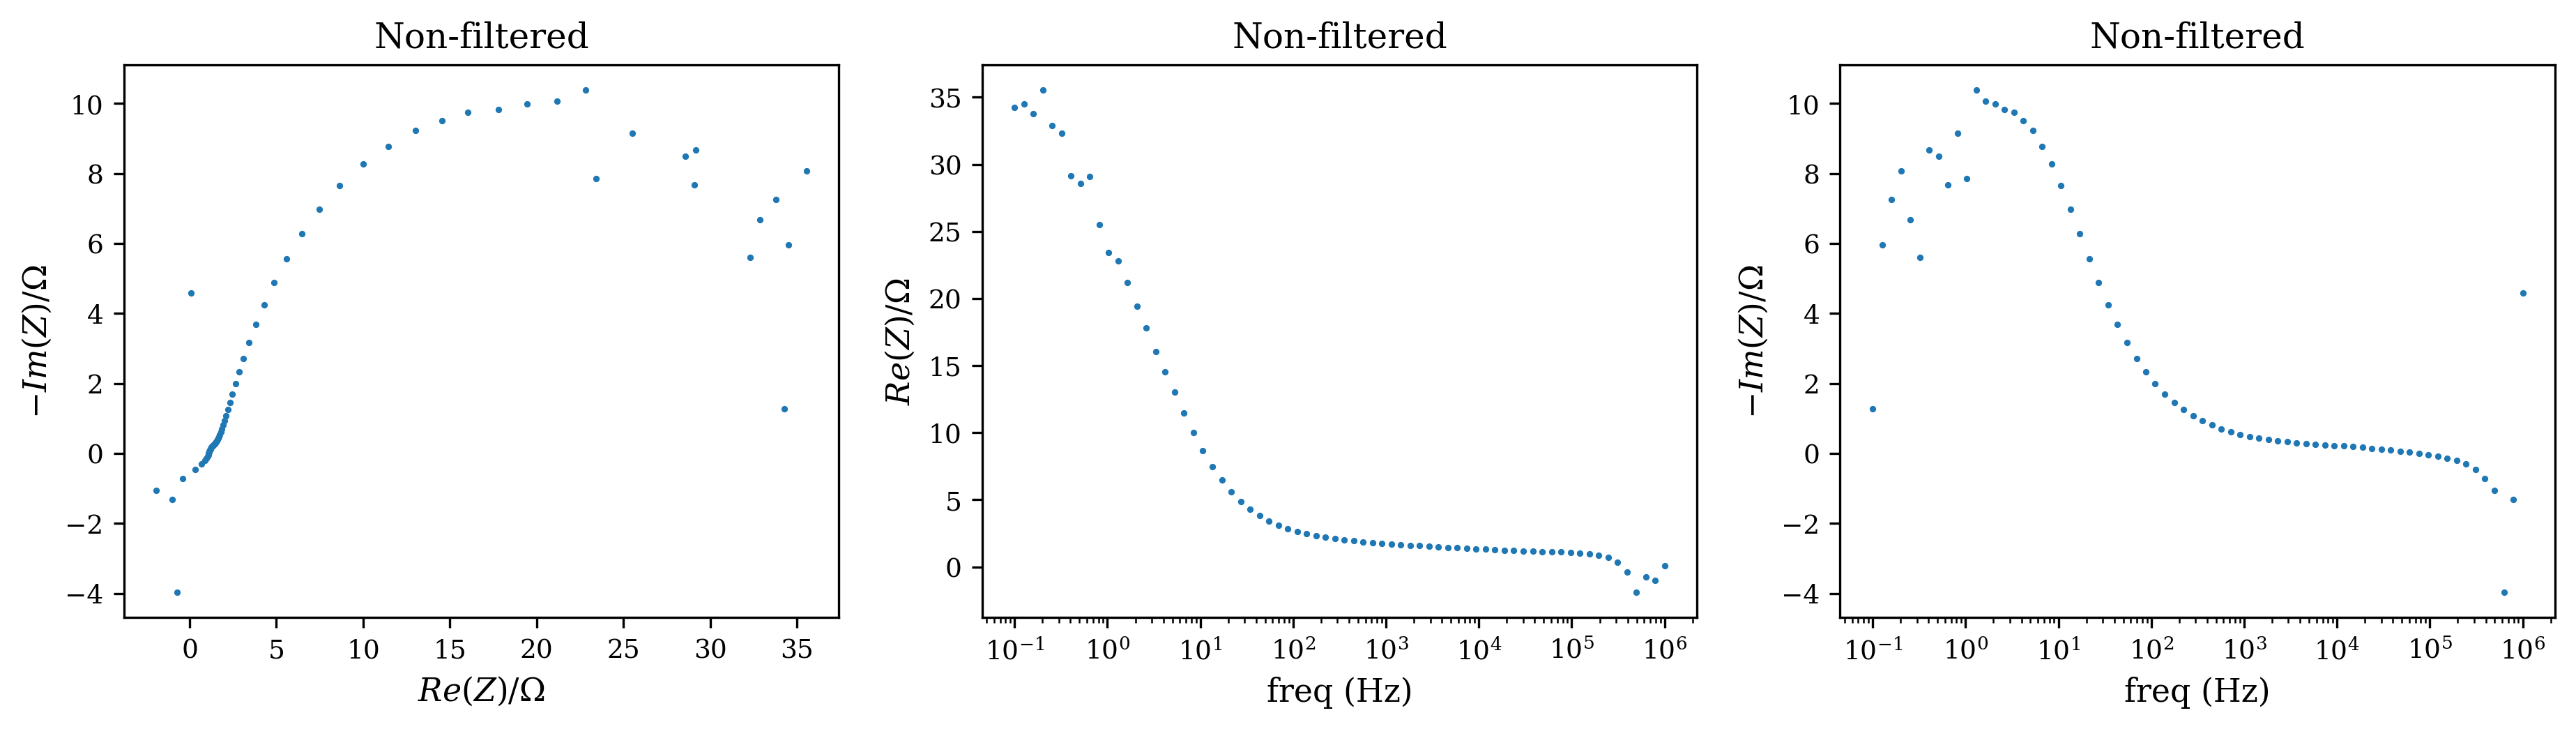

10 1.0 0.8013387343657297
ohmic_resistance = 1.09364688355102


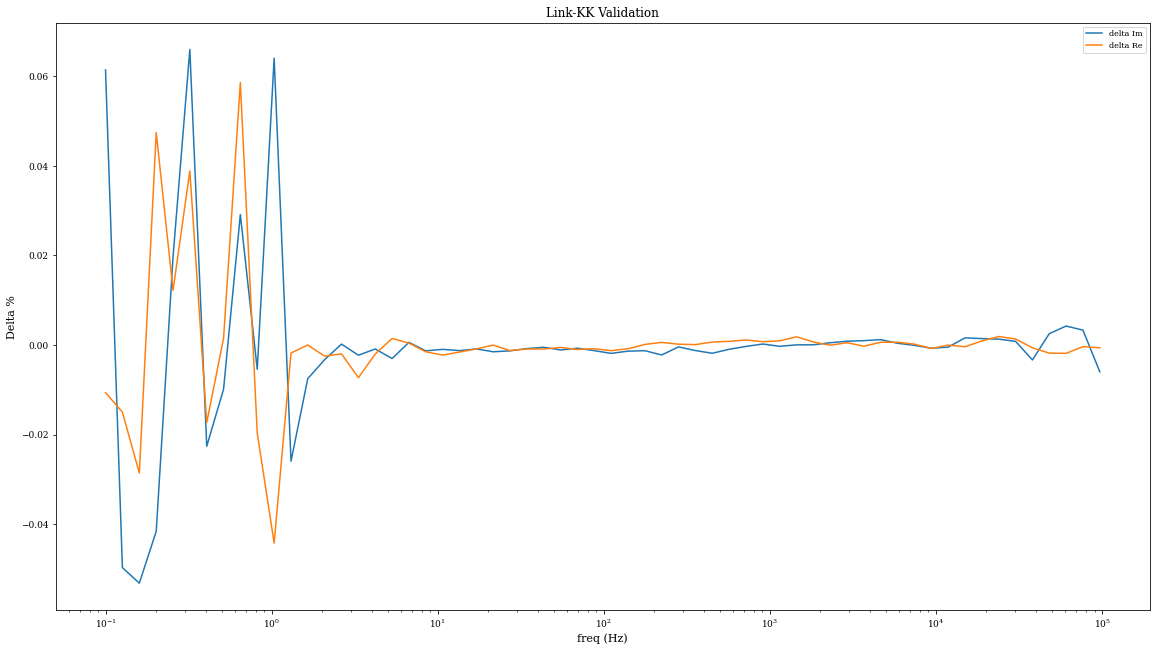

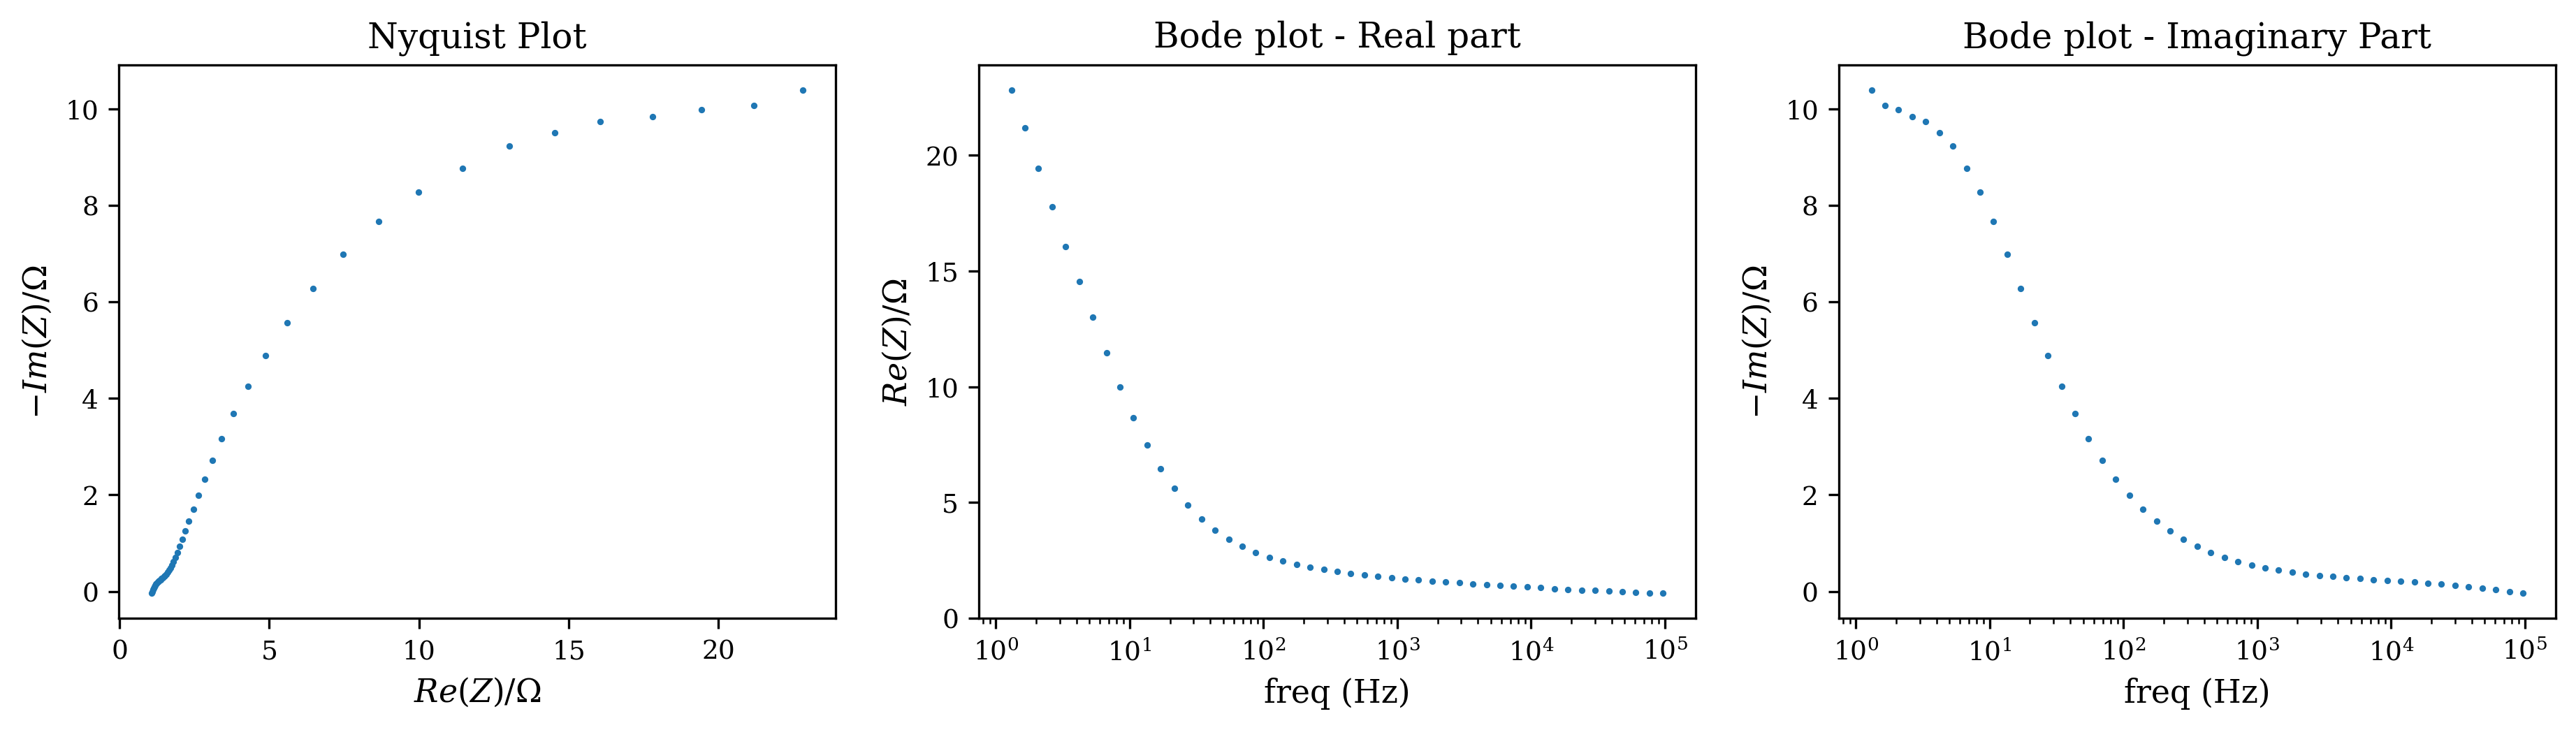

ImportError: <PyCall.jlwrap (in a Julia function called from Python)
JULIA: LoadError: InitError: could not load library "libdSFMT"
The specified module could not be found. 
Stacktrace:
  [1] dsfmt_init_by_array
    @ D:\Julia-1.7.2\share\julia\stdlib\v1.7\Random\src\DSFMT.jl:69 [inlined]
  [2] seed!(r::Random.MersenneTwister, seed::Vector{UInt32})
    @ Random D:\Julia-1.7.2\share\julia\stdlib\v1.7\Random\src\RNGs.jl:361
  [3] seed!
    @ D:\Julia-1.7.2\share\julia\stdlib\v1.7\Random\src\RNGs.jl:368 [inlined]
  [4] seed!
    @ D:\Julia-1.7.2\share\julia\stdlib\v1.7\Random\src\Random.jl:433 [inlined]
  [5] Random.MersenneTwister(seed::Nothing) (repeats 2 times)
    @ Random D:\Julia-1.7.2\share\julia\stdlib\v1.7\Random\src\RNGs.jl:153
  [6] __init__()
    @ SentinelArrays C:\Users\97486\.julia\packages\SentinelArrays\p1IoM\src\SentinelArrays.jl:13
  [7] _include_from_serialized(path::String, depmods::Vector{Any})
    @ Base .\loading.jl:768
  [8] _require_search_from_serialized(pkg::Base.PkgId, sourcepath::String)
    @ Base .\loading.jl:854
  [9] _tryrequire_from_serialized(modkey::Base.PkgId, build_id::UInt64, modpath::String)
    @ Base .\loading.jl:783
 [10] _require_search_from_serialized(pkg::Base.PkgId, sourcepath::String)
    @ Base .\loading.jl:843
 [11] _require(pkg::Base.PkgId)
    @ Base .\loading.jl:1097
 [12] require(uuidkey::Base.PkgId)
    @ Base .\loading.jl:1013
 [13] require(into::Module, mod::Symbol)
    @ Base .\loading.jl:997
 [14] include(fname::String)
    @ Base.MainInclude .\client.jl:451
 [15] invokelatest(::Any, ::Any, ::Vararg{Any}; kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ Base .\essentials.jl:716
 [16] invokelatest(::Any, ::Any, ::Vararg{Any})
    @ Base .\essentials.jl:714
 [17] _pyjlwrap_call(f::Function, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
    @ PyCall C:\Users\97486\.julia\packages\PyCall\L0fLP\src\callback.jl:28
 [18] pyjlwrap_call(self_::Ptr{PyCall.PyObject_struct}, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
    @ PyCall C:\Users\97486\.julia\packages\PyCall\L0fLP\src\callback.jl:44
during initialization of module SentinelArrays
in expression starting at D:\Personal Document\Studying in Canada\UOT-courses\test_julia_no_capacitors.jl:2>

In [38]:
# the demonstration of the error mentioned above (it only shows up at the first time calling julia program)
results = ECMs_fitting(impedance = measurements, freq = frequencies, data_path = data_path)

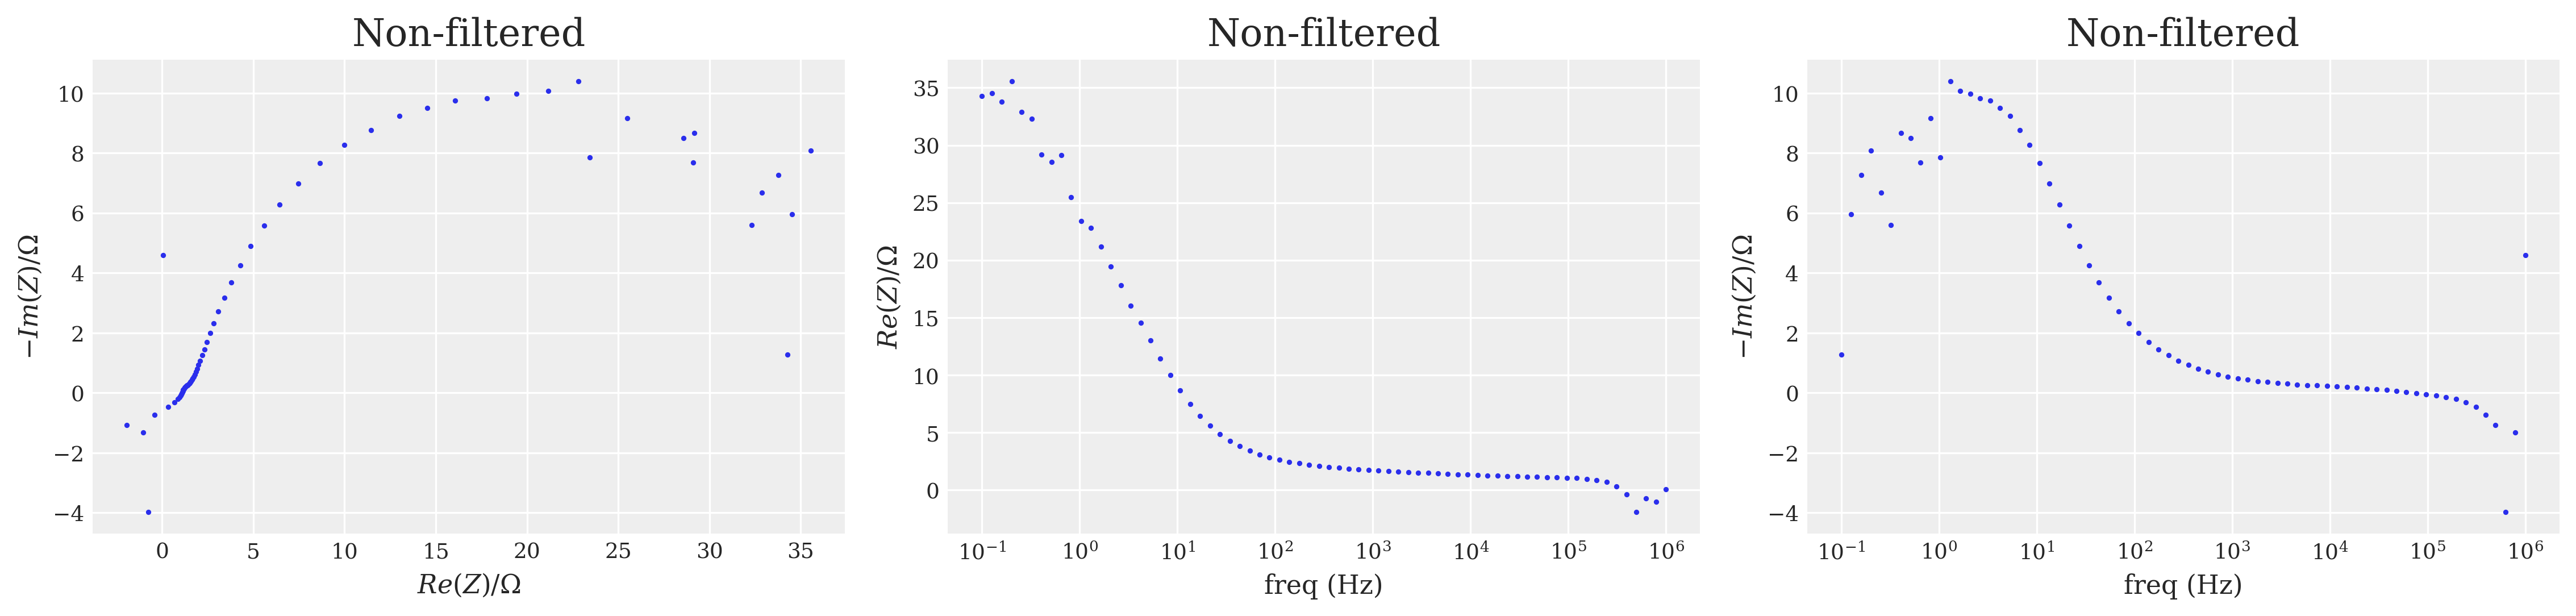

10 1.0 0.8013387343657297
ohmic_resistance = 1.09364688355102


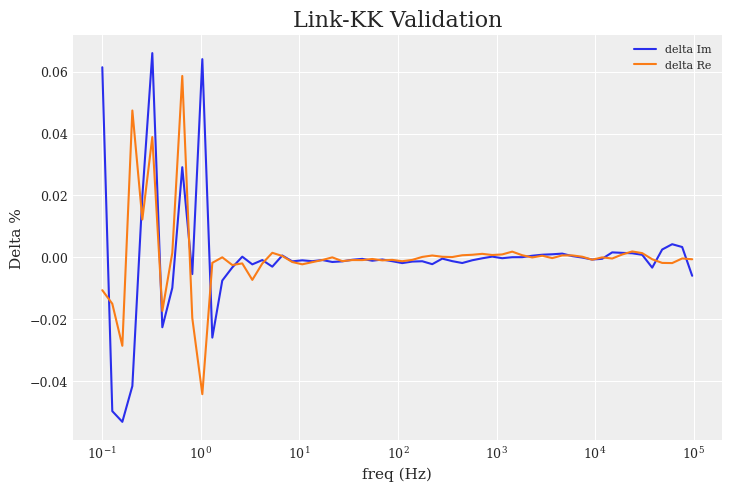

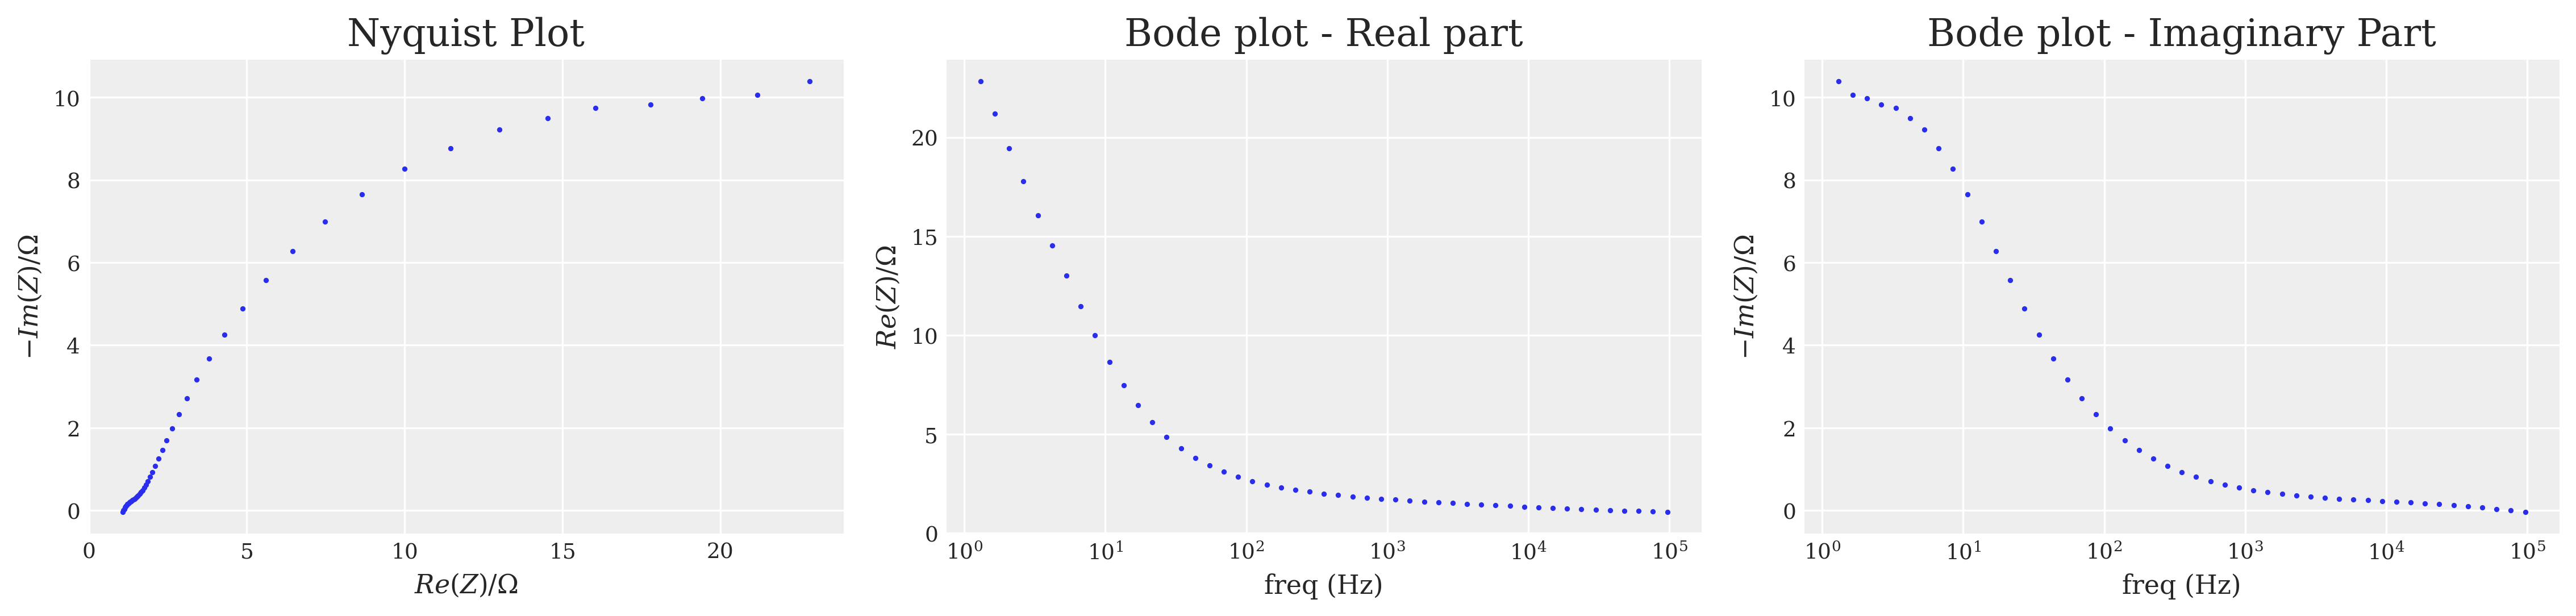

Circuit 0:[R1-P2,[P3,P4]]-R5 composed of components (['R1', 'P2w', 'P2n', 'P3w', 'P3n', 'P4w', 'P4n', 'R5']) with values ([0.7638, 412.5341, 0.754, 2935.6713, 0.8084, 35.938, 0.086, 1.1201])


sample: 100%|██████████████████████████| 1500/1500 [00:14<00:00, 106.07it/s, 63 steps of size 7.39e-02. acc. prob=0.97]


[R1-P2,[P3,P4]]-R5:Prior distributions with trajectories


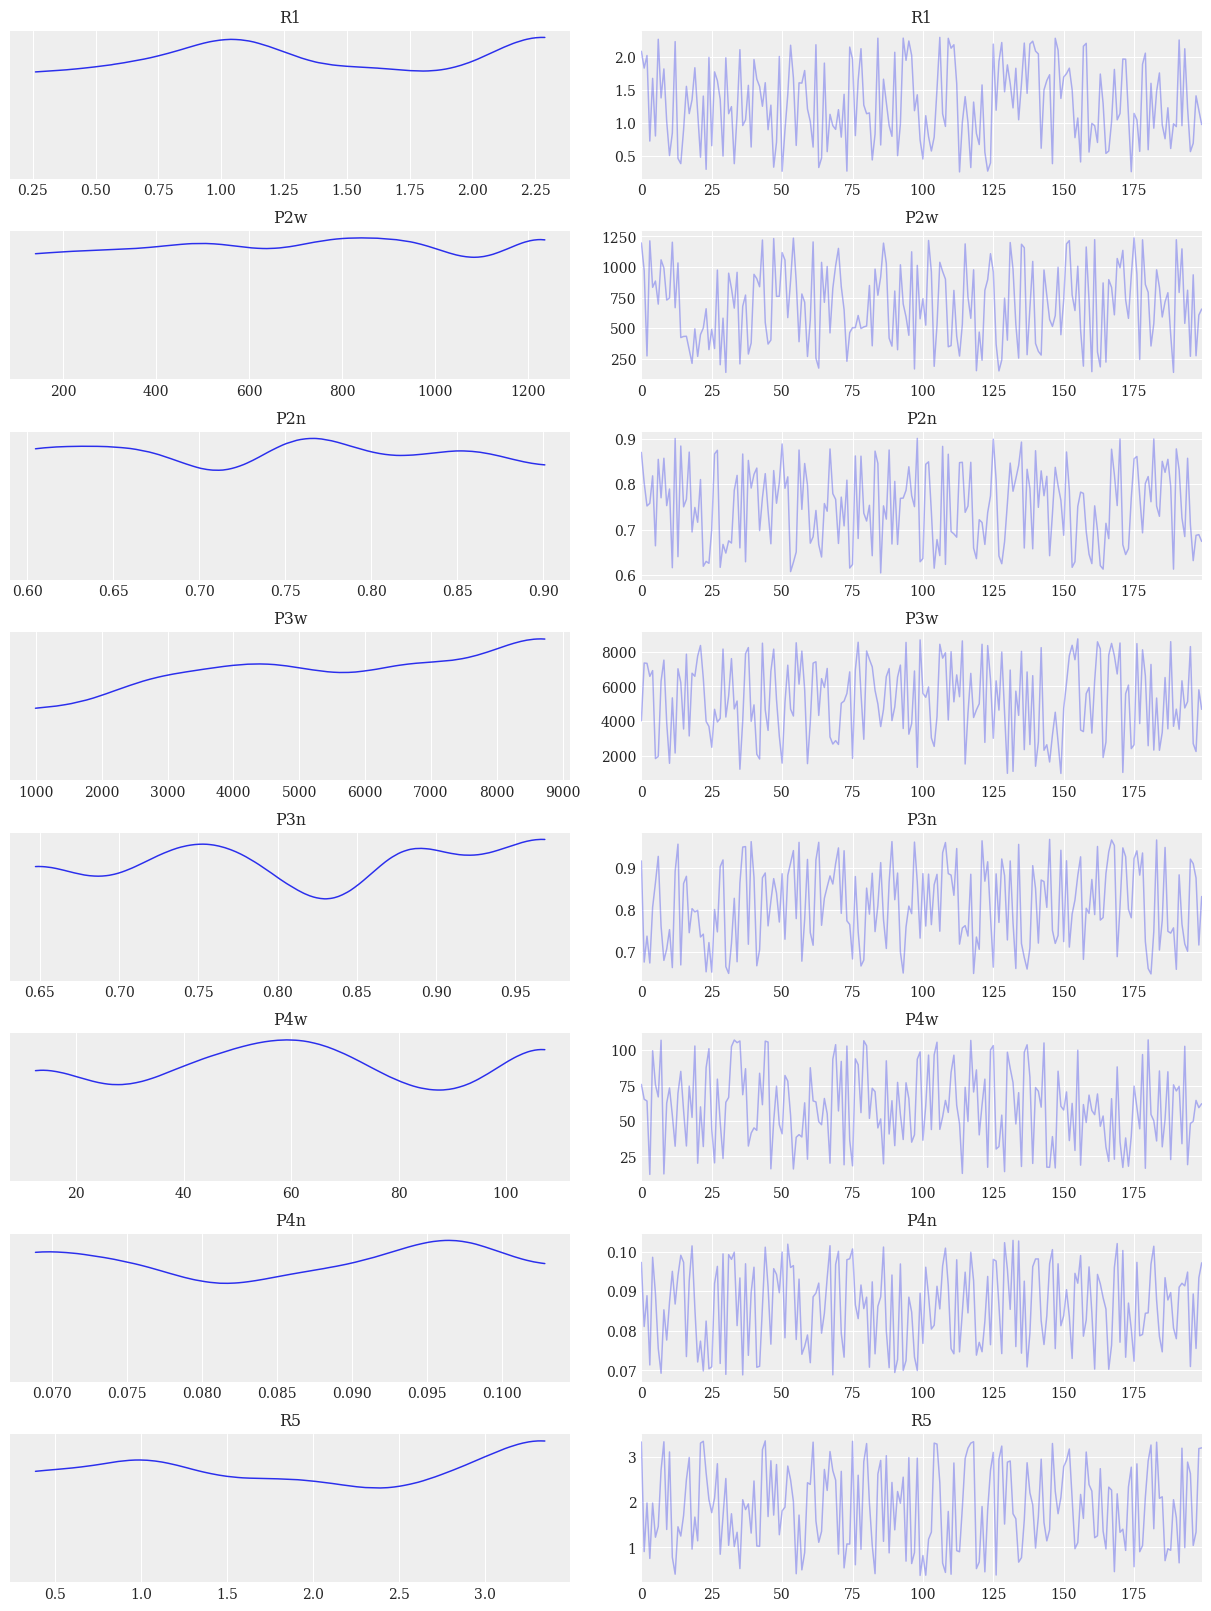

[R1-P2,[P3,P4]]-R5:Prior prediction


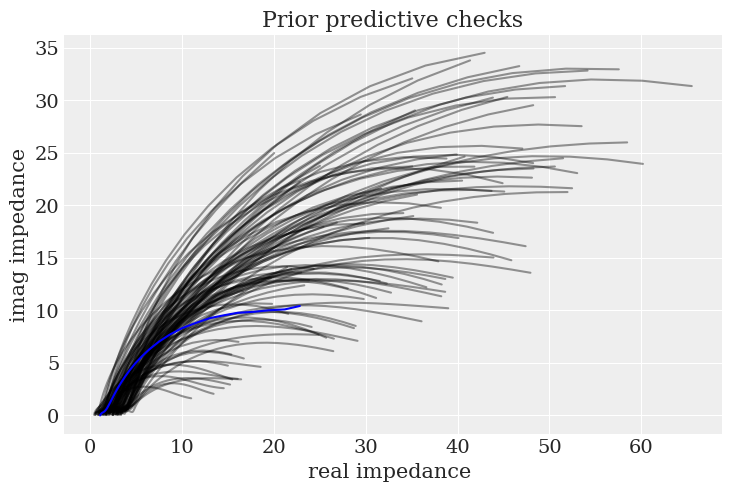

[R1-P2,[P3,P4]]-R5:Posterior distributions with HDI


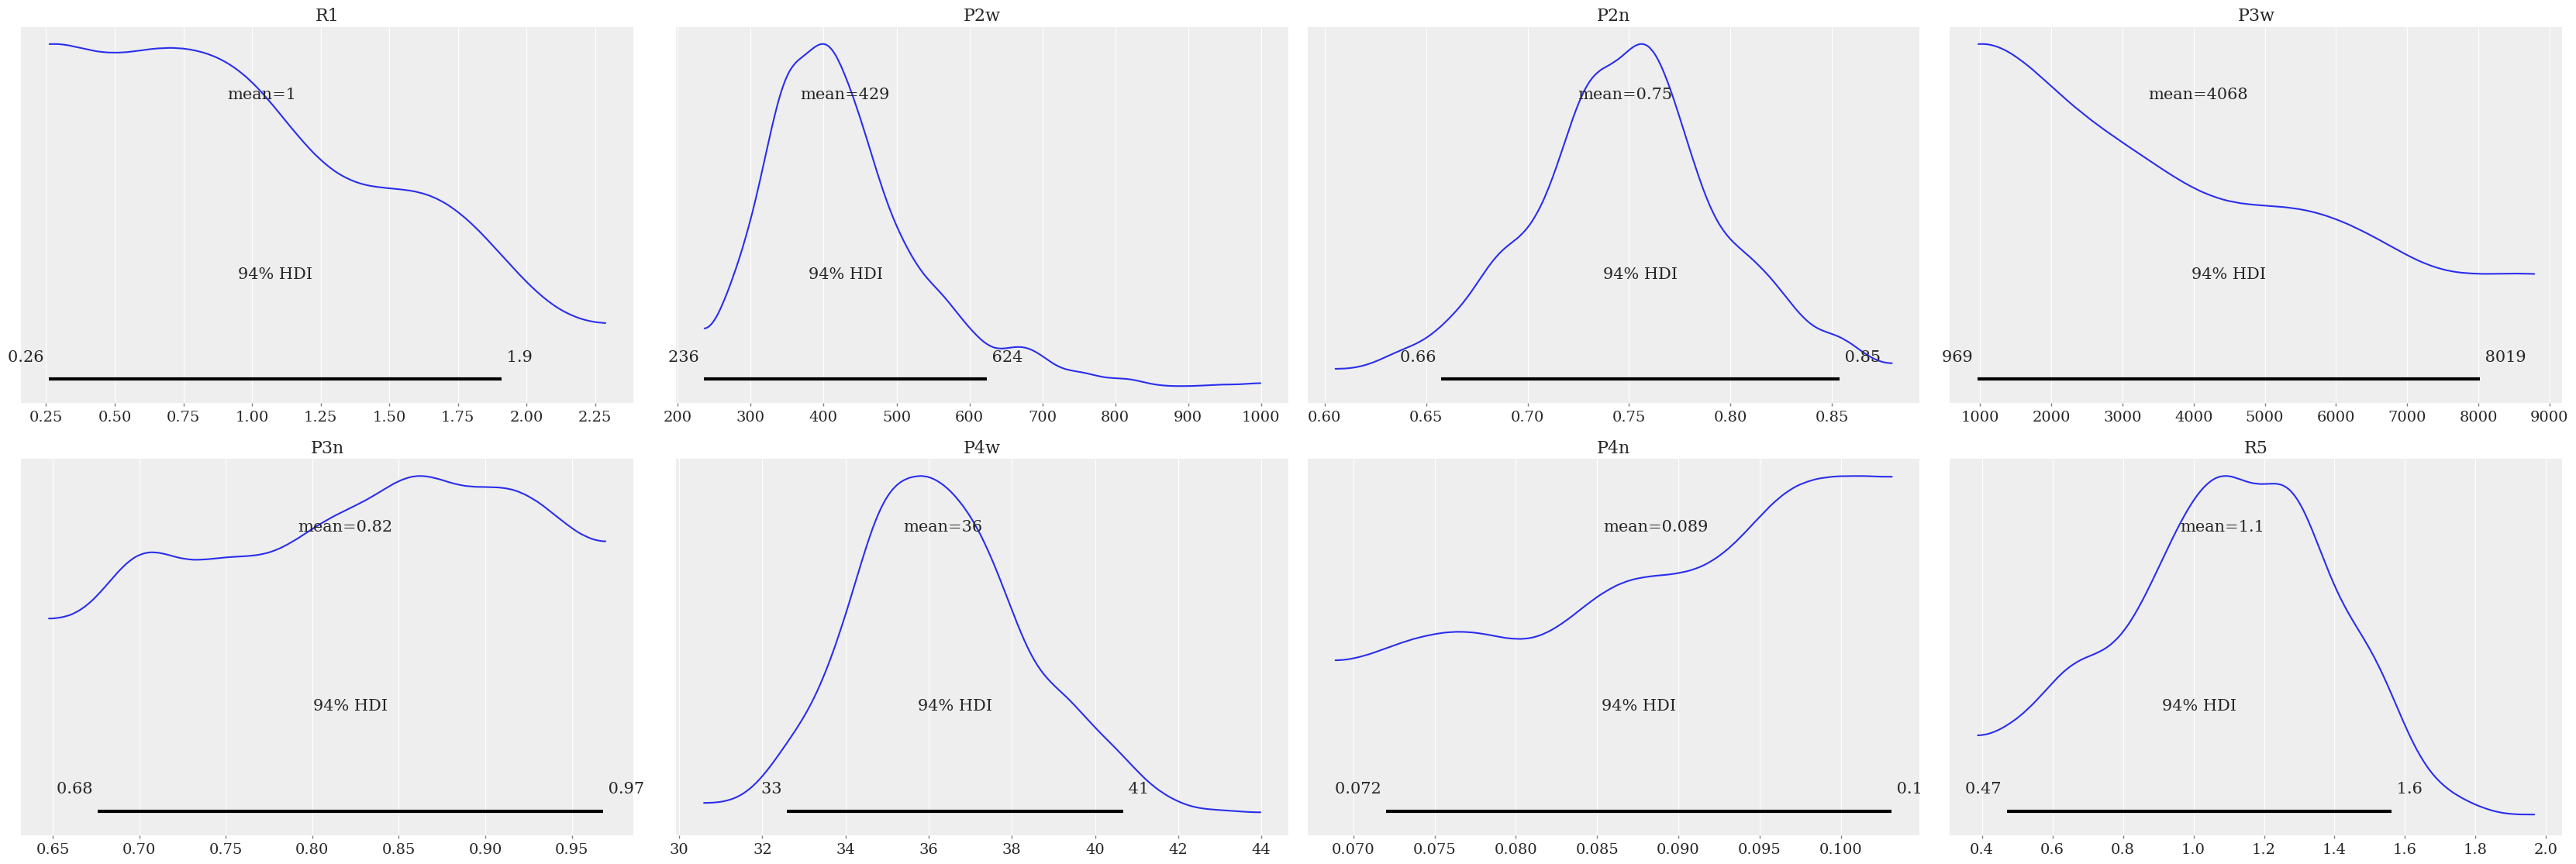

[R1-P2,[P3,P4]]-R5:Posterior distributions with trajectories


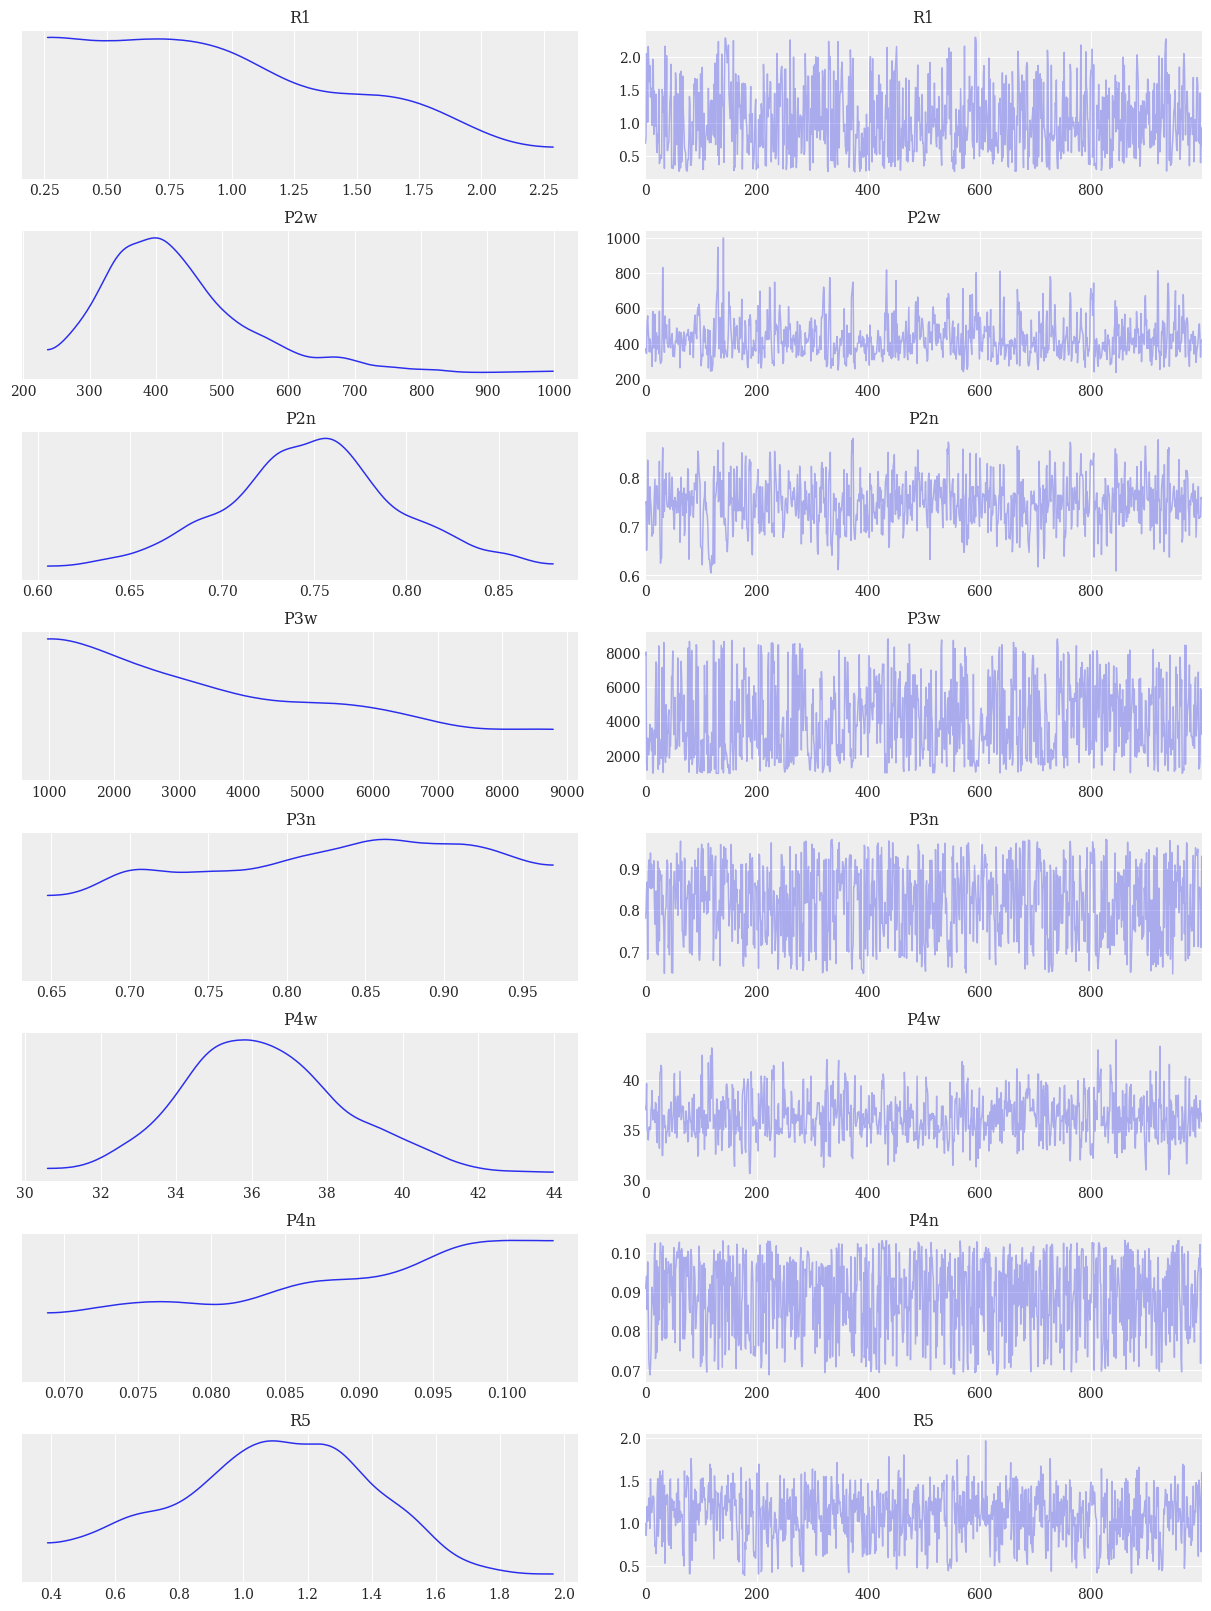

[R1-P2,[P3,P4]]-R5:Posterior predictions


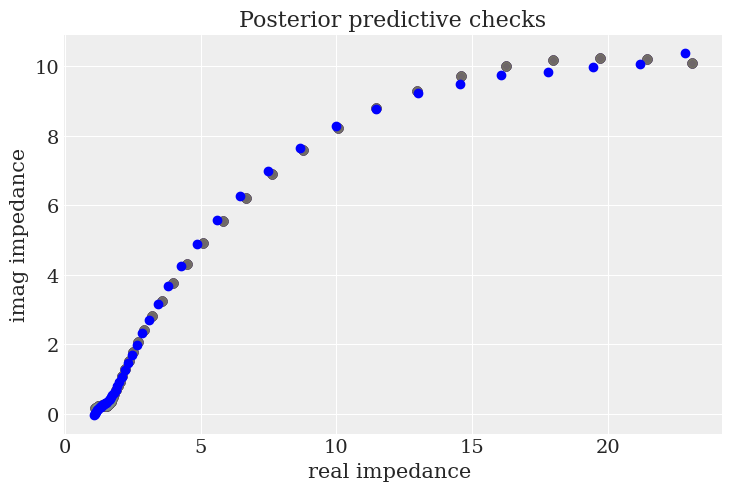

Circuit 1:[P1,P2]-[P3,P4]-R5 composed of components (['P1w', 'P1n', 'P2w', 'P2n', 'P3w', 'P3n', 'P4w', 'P4n', 'R5']) with values ([33.2177, 0.1345, 491.4887, 0.8468, 3.468, 0.2029, 31024.5587, 1.0, 1.1298])


sample: 100%|██████████████████████████| 1500/1500 [00:11<00:00, 131.84it/s, 31 steps of size 1.13e-01. acc. prob=0.94]


[P1,P2]-[P3,P4]-R5:Prior distributions with trajectories


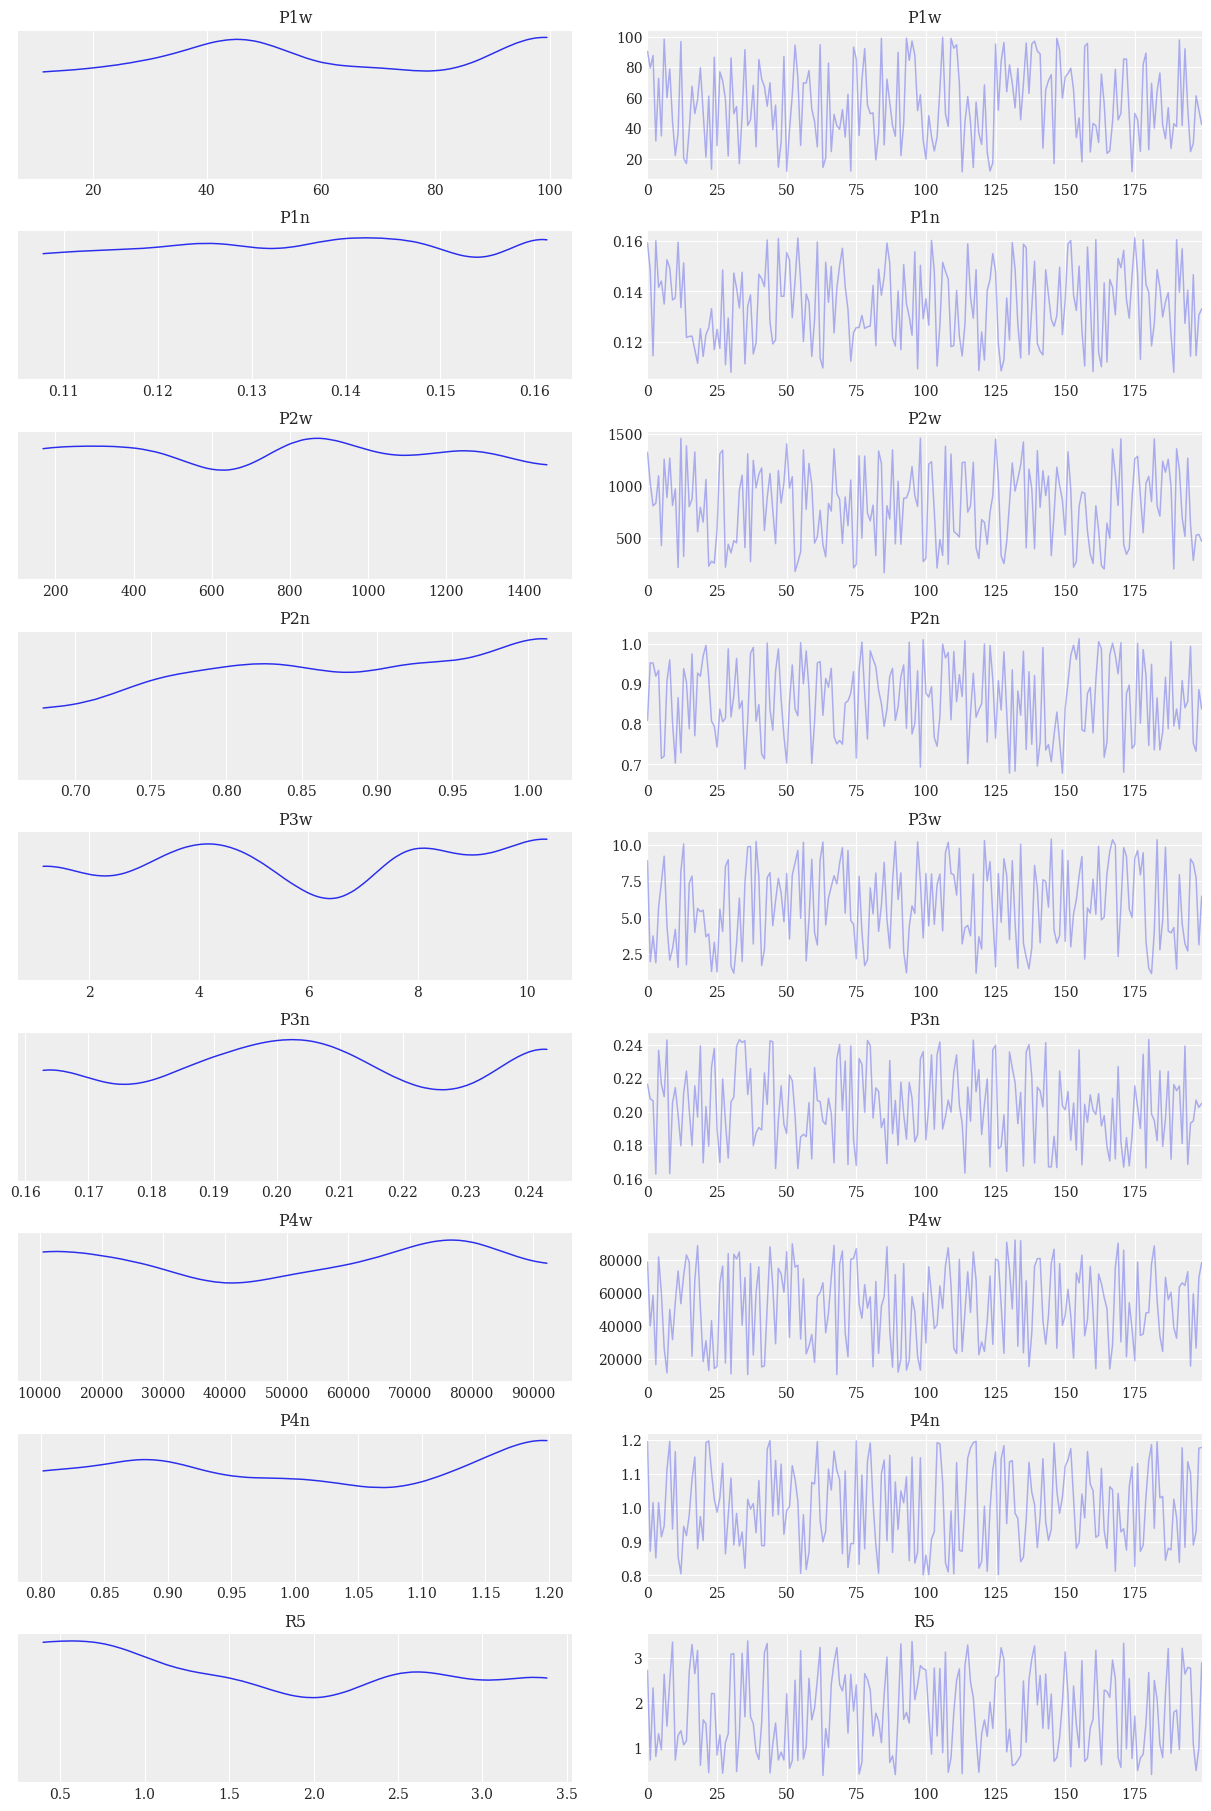

[P1,P2]-[P3,P4]-R5:Prior prediction


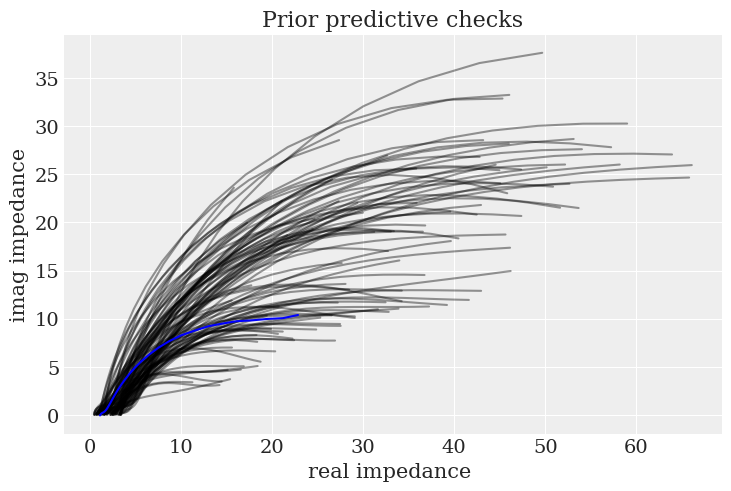

[P1,P2]-[P3,P4]-R5:Posterior distributions with HDI


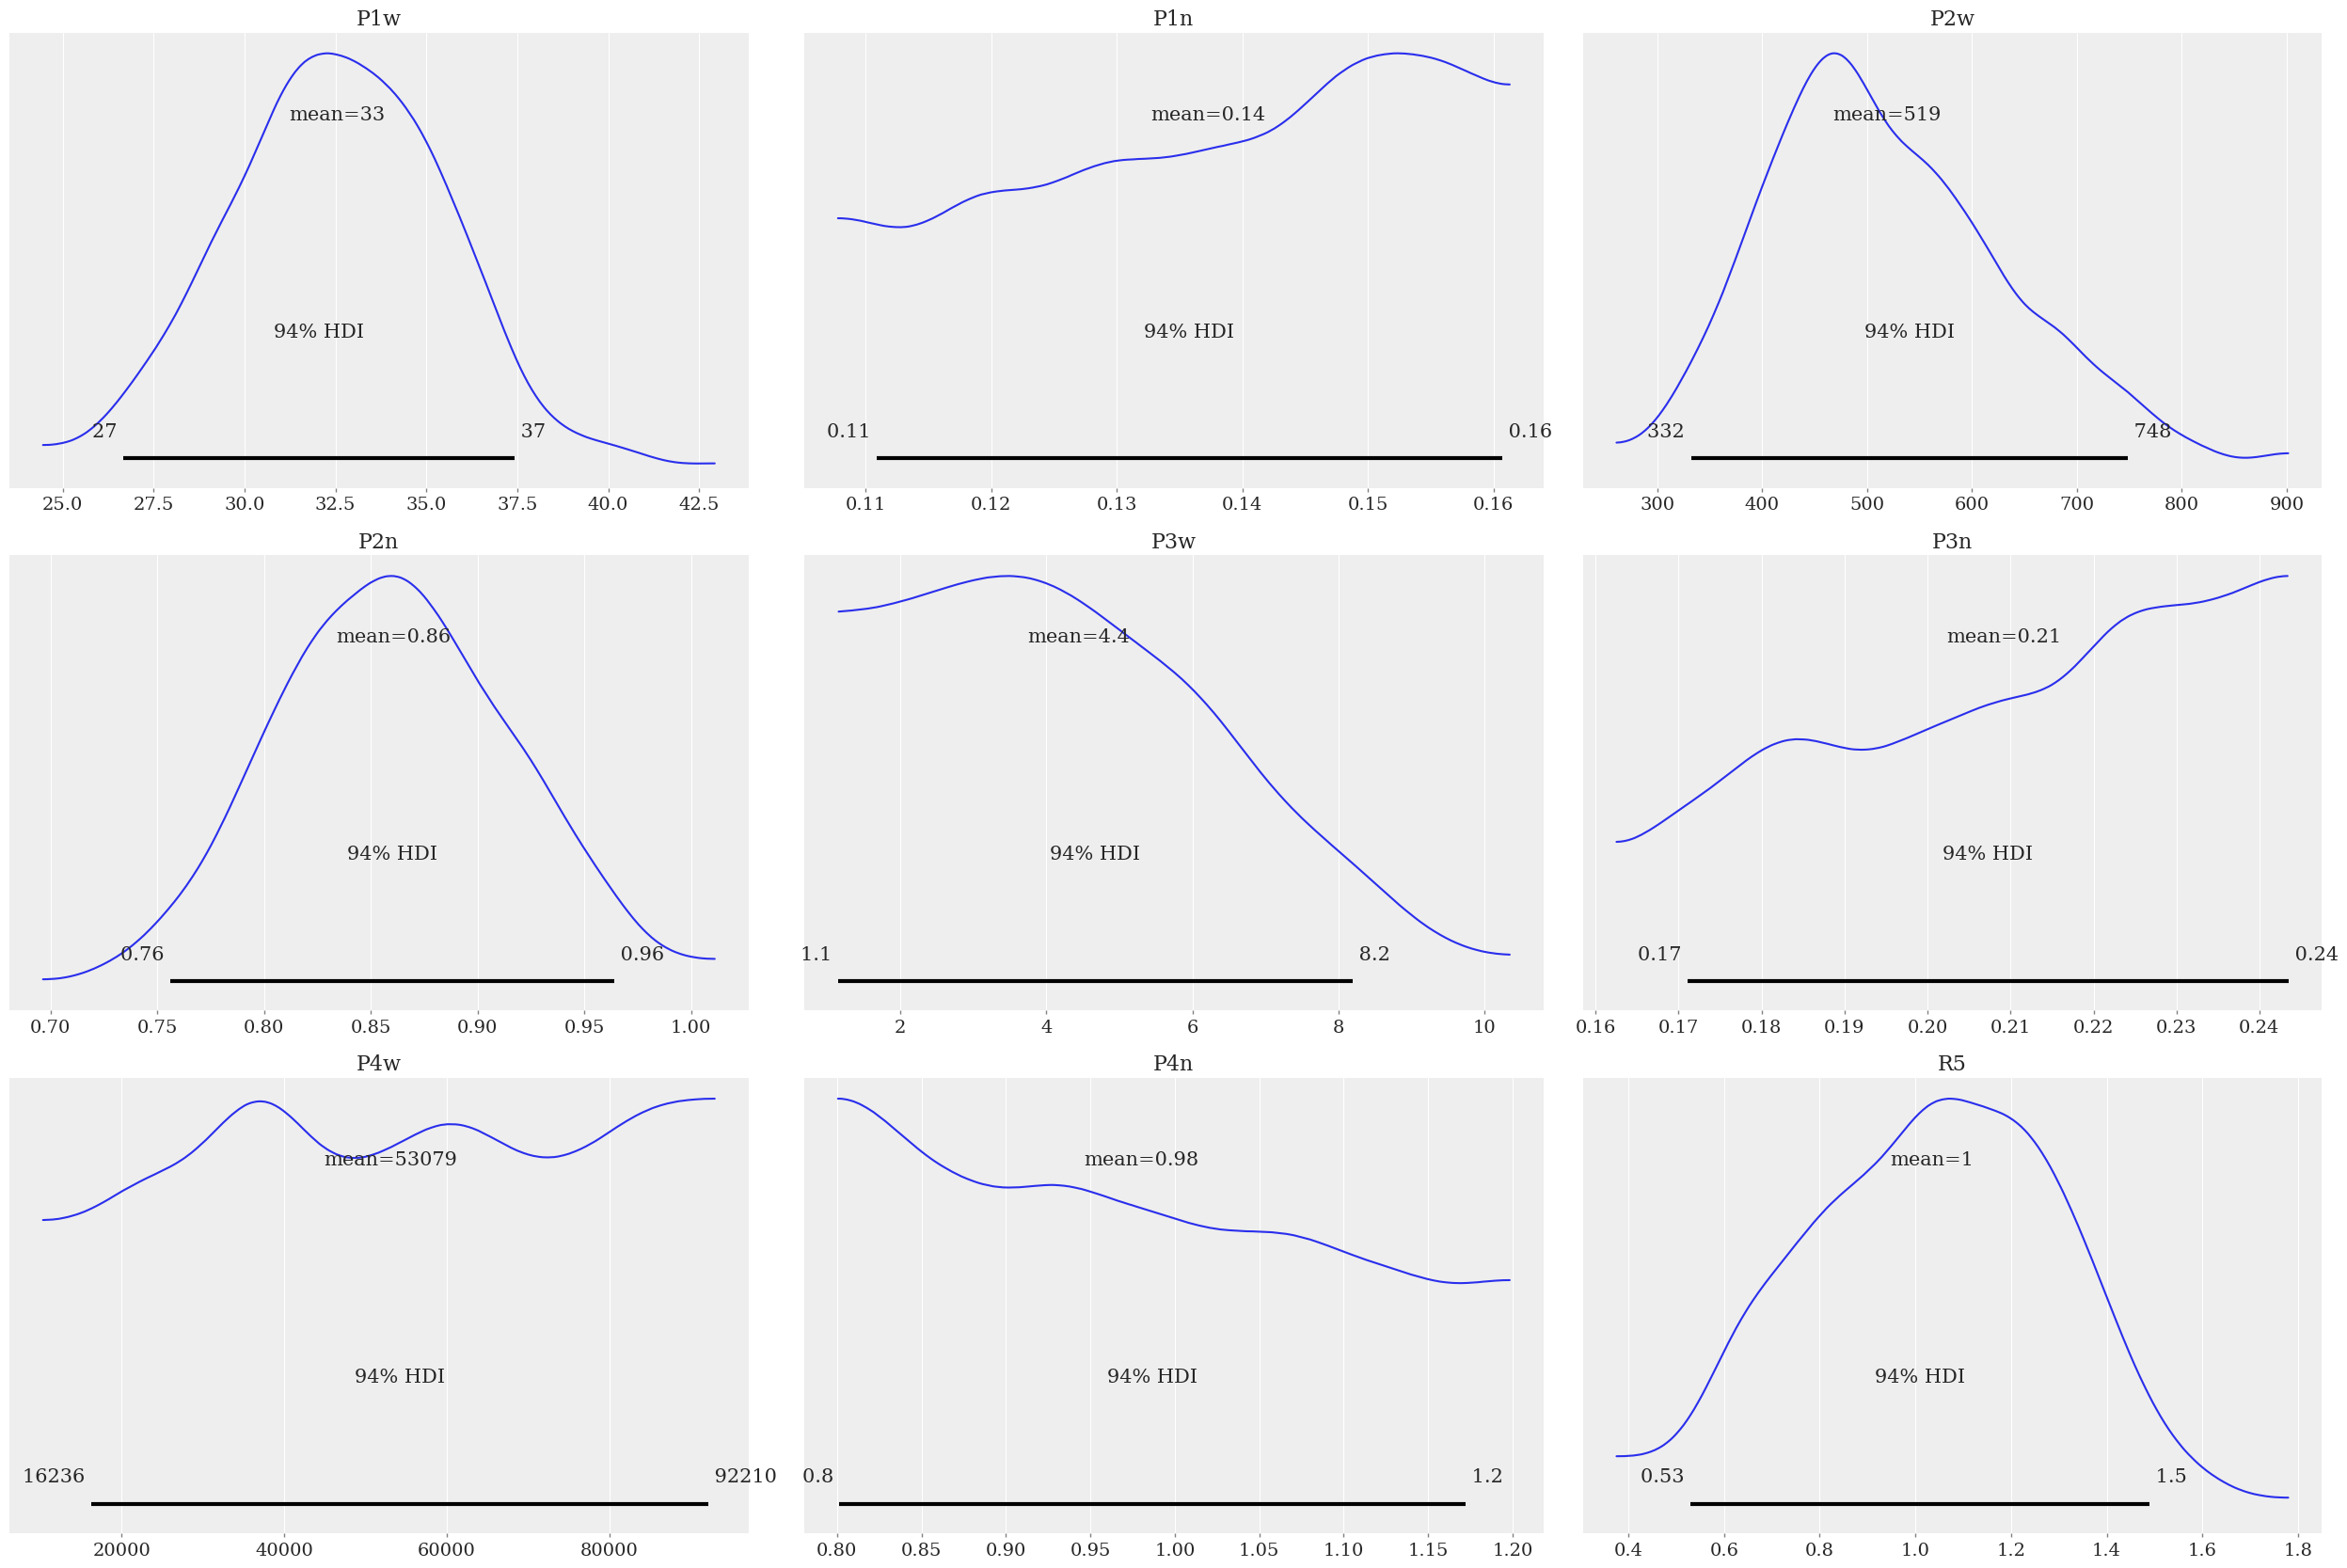

[P1,P2]-[P3,P4]-R5:Posterior distributions with trajectories


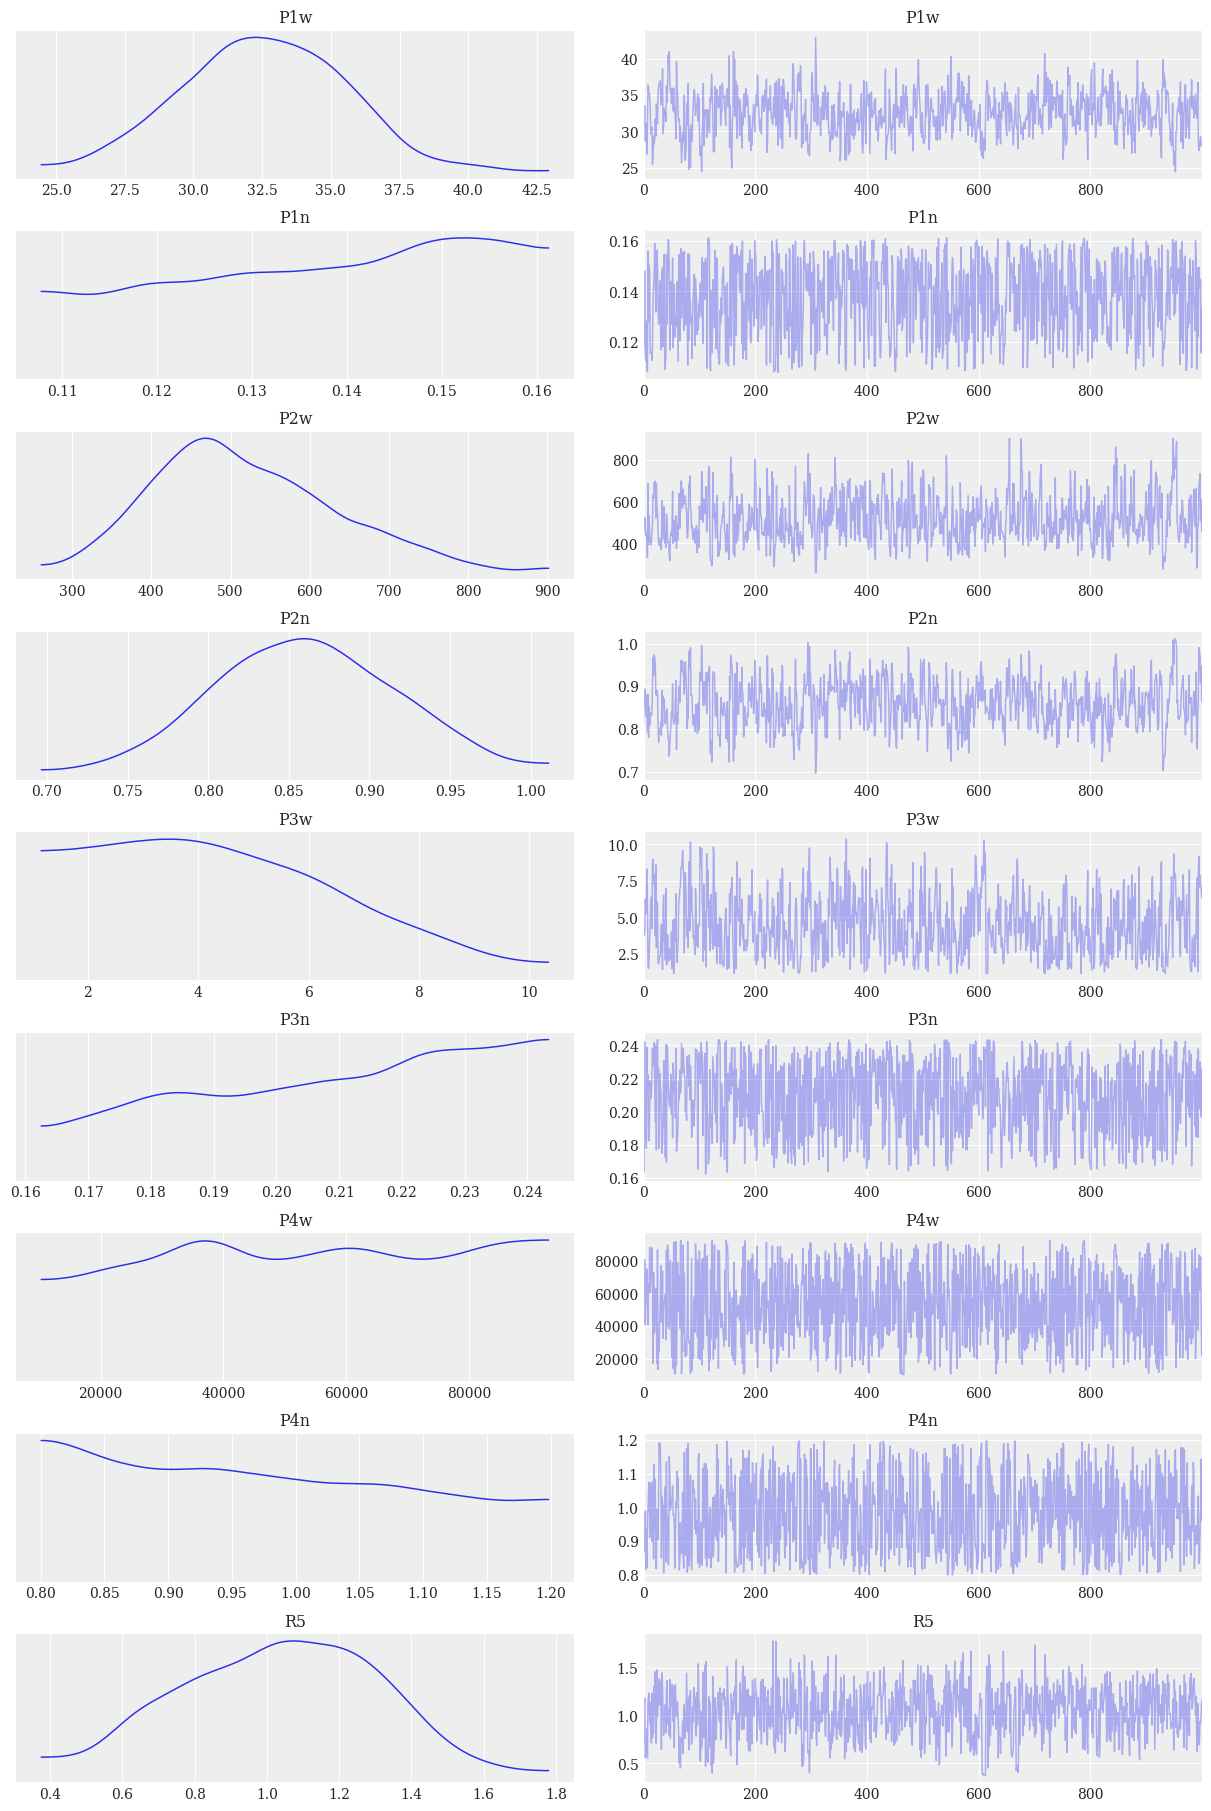

[P1,P2]-[P3,P4]-R5:Posterior predictions


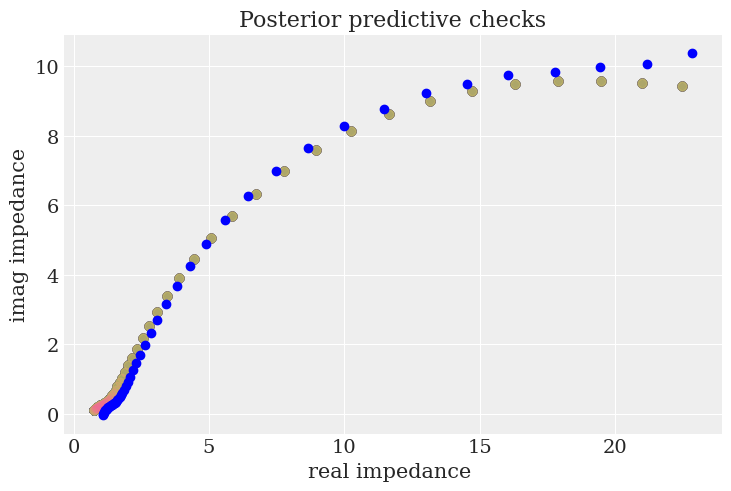

Circuit 2:[P1,R2]-[P3,P4]-R5 composed of components (['P1w', 'P1n', 'R2', 'P3w', 'P3n', 'P4w', 'P4n', 'R5']) with values ([251.8375, 0.7164, 31.6293, 0.6679, 0.0633, 14492.8093, 0.971, 1.1299])


sample: 100%|██████████████████████████| 1500/1500 [00:09<00:00, 155.67it/s, 31 steps of size 1.14e-01. acc. prob=0.96]


[P1,R2]-[P3,P4]-R5:Prior distributions with trajectories


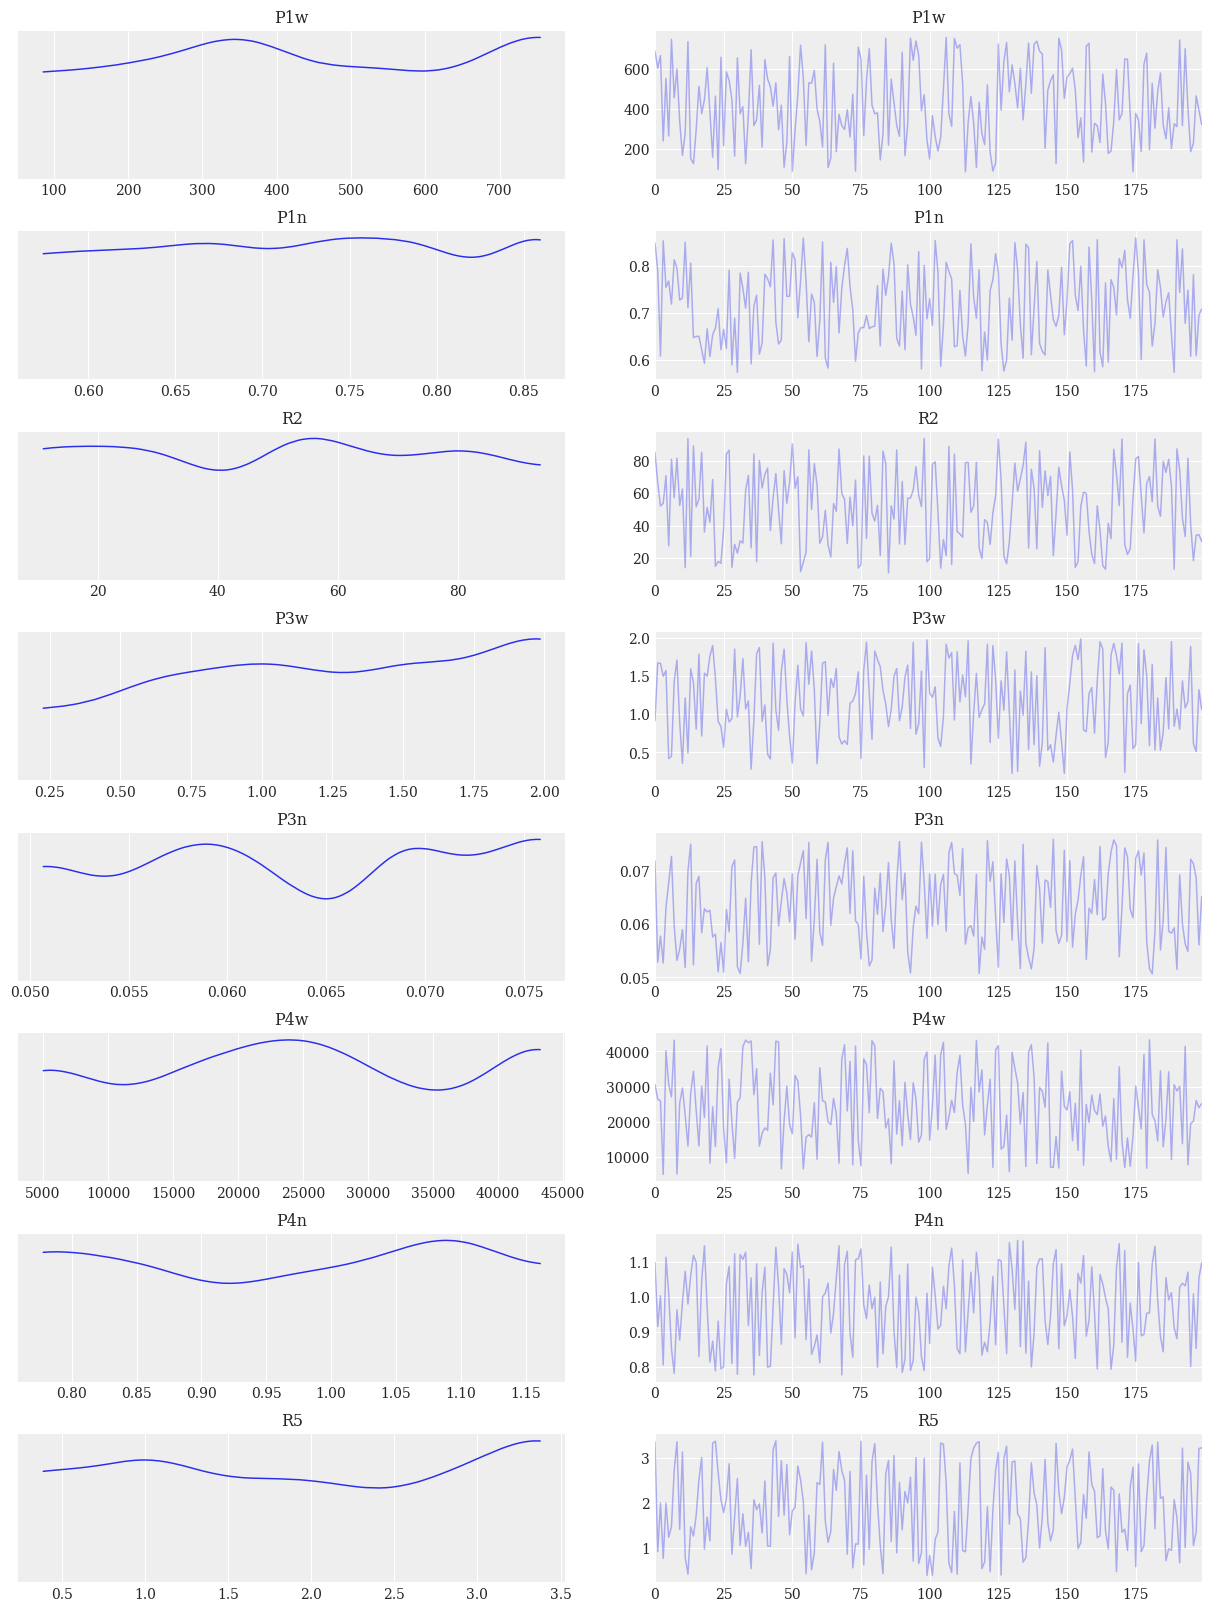

[P1,R2]-[P3,P4]-R5:Prior prediction


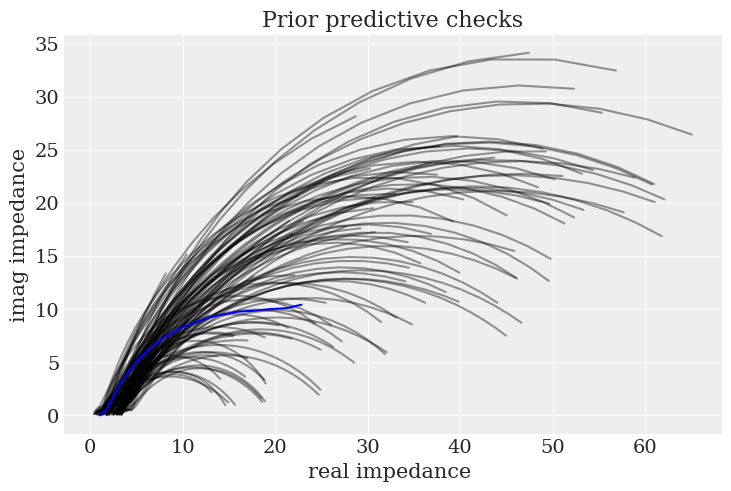

[P1,R2]-[P3,P4]-R5:Posterior distributions with HDI


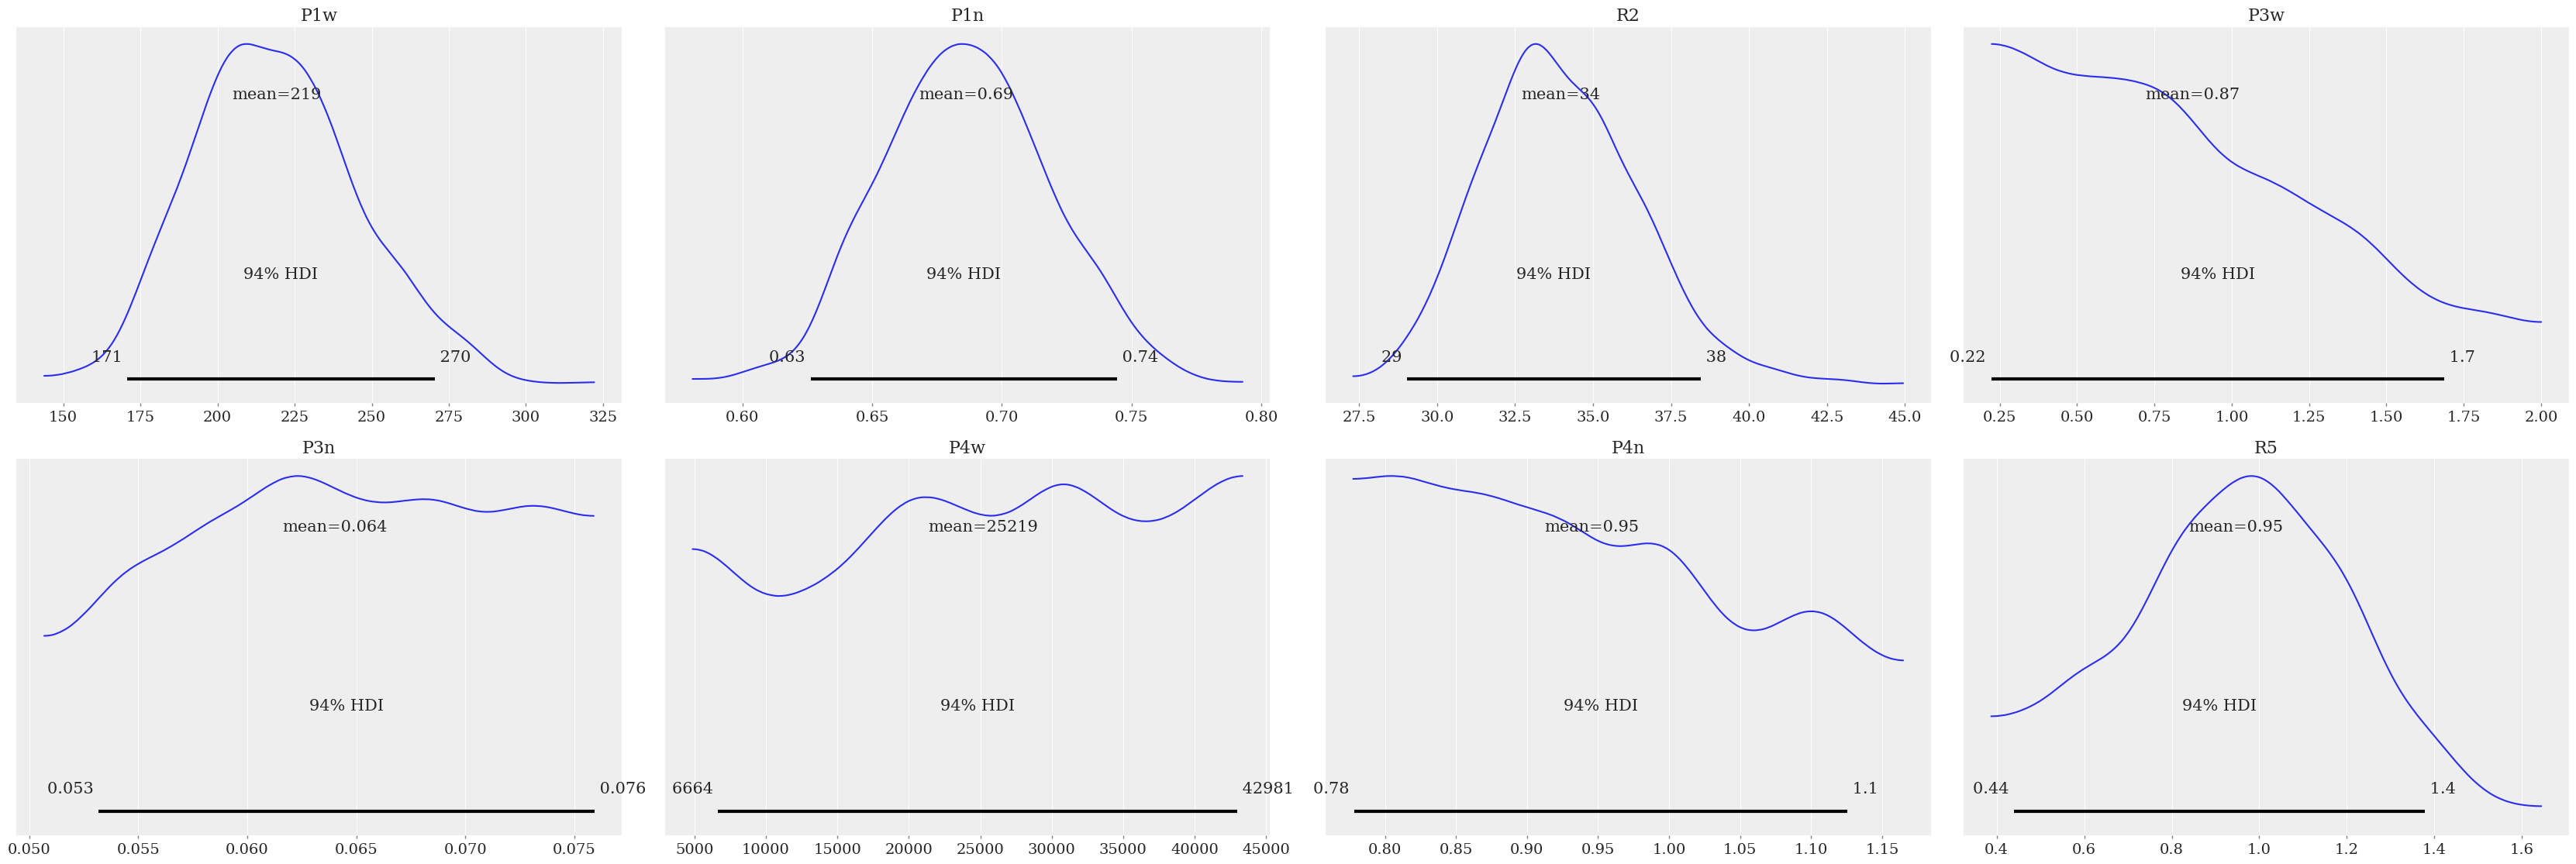

[P1,R2]-[P3,P4]-R5:Posterior distributions with trajectories


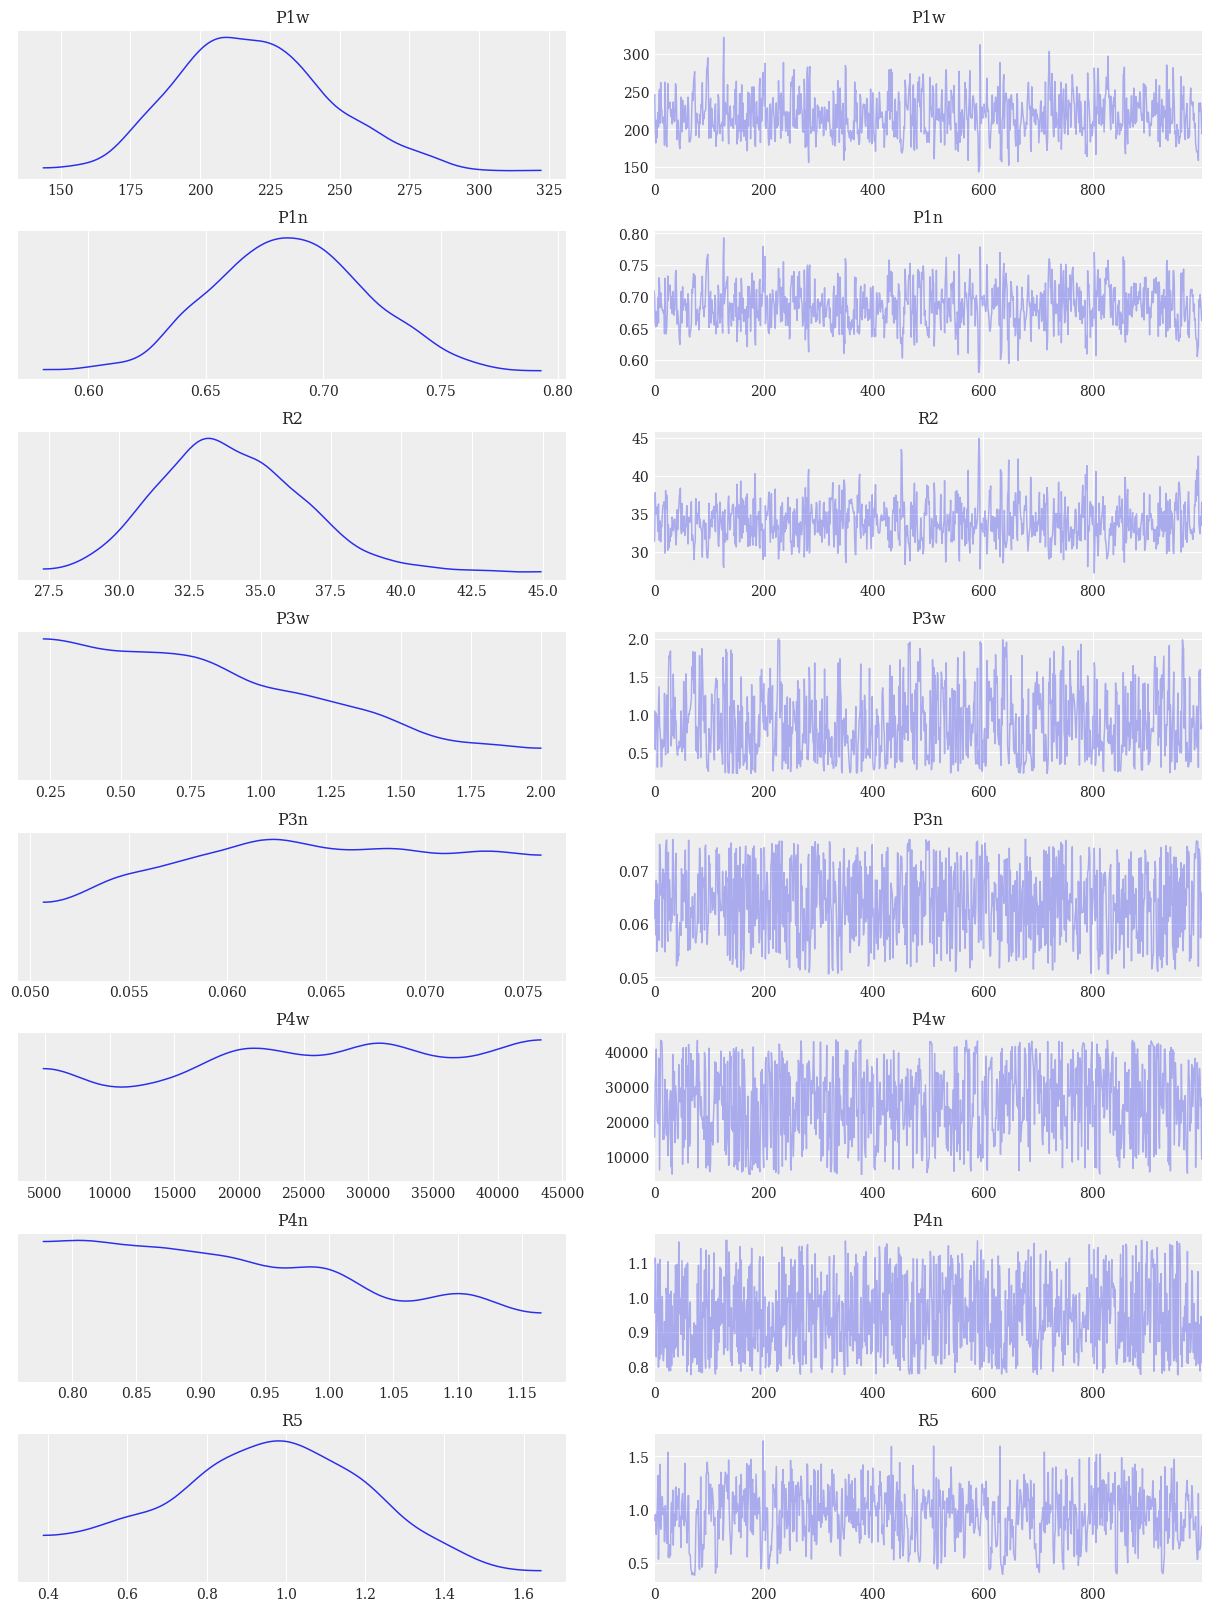

[P1,R2]-[P3,P4]-R5:Posterior predictions


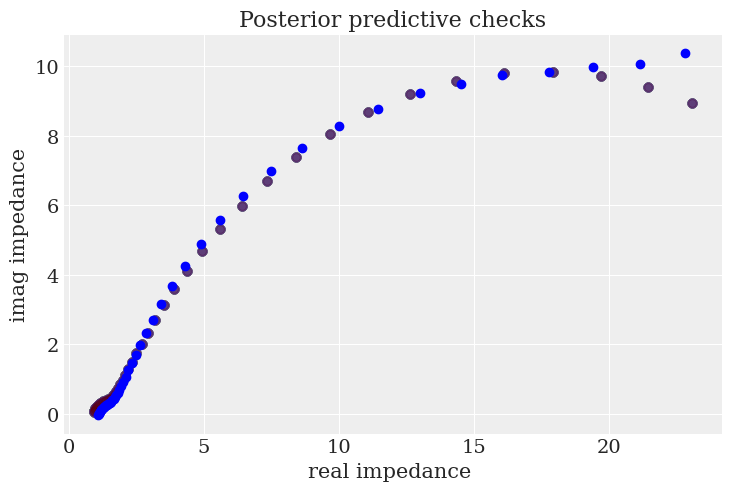

Circuit 3:R1-[P2,P3]-P4 composed of components (['R1', 'P2w', 'P2n', 'P3w', 'P3n', 'P4w', 'P4n']) with values ([0.9346, 674.103, 0.9516, 27.0946, 0.1644, 11.4134, 0.2978])


sample: 100%|██████████████████████████| 1500/1500 [00:12<00:00, 121.23it/s, 63 steps of size 6.75e-02. acc. prob=0.94]


R1-[P2,P3]-P4:Prior distributions with trajectories


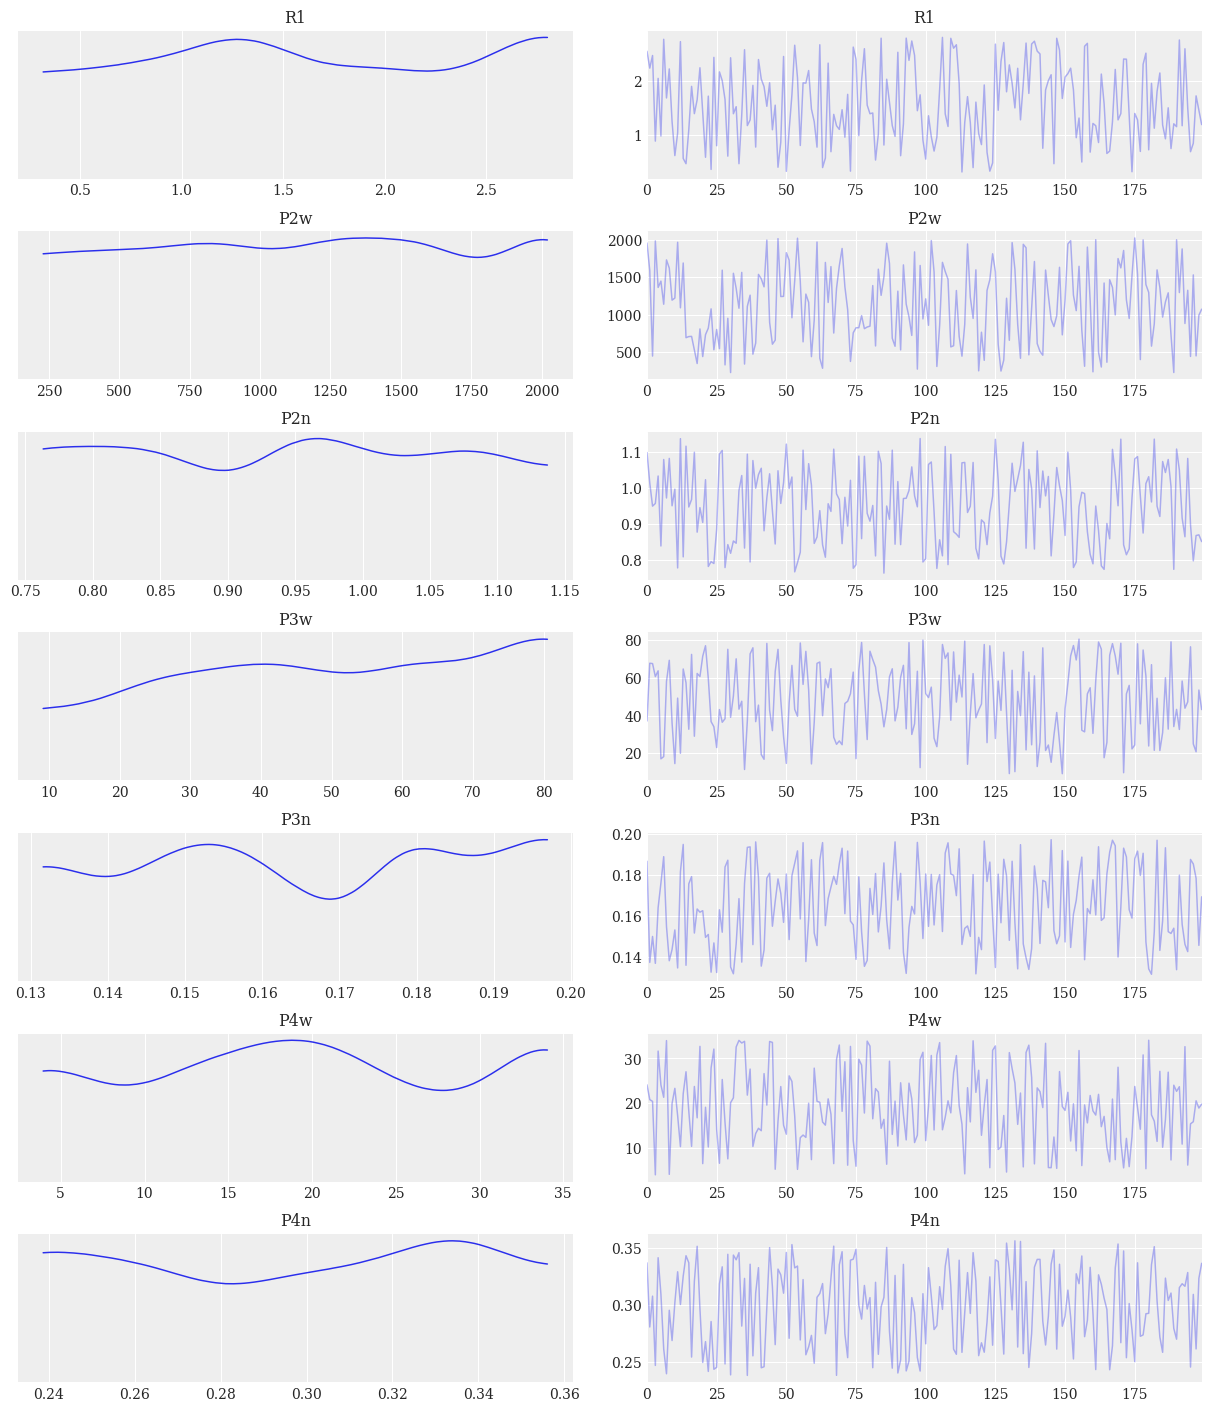

R1-[P2,P3]-P4:Prior prediction


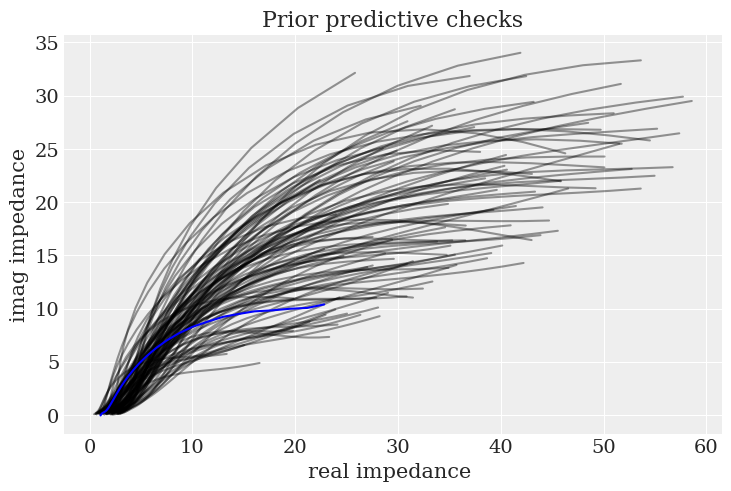

R1-[P2,P3]-P4:Posterior distributions with HDI


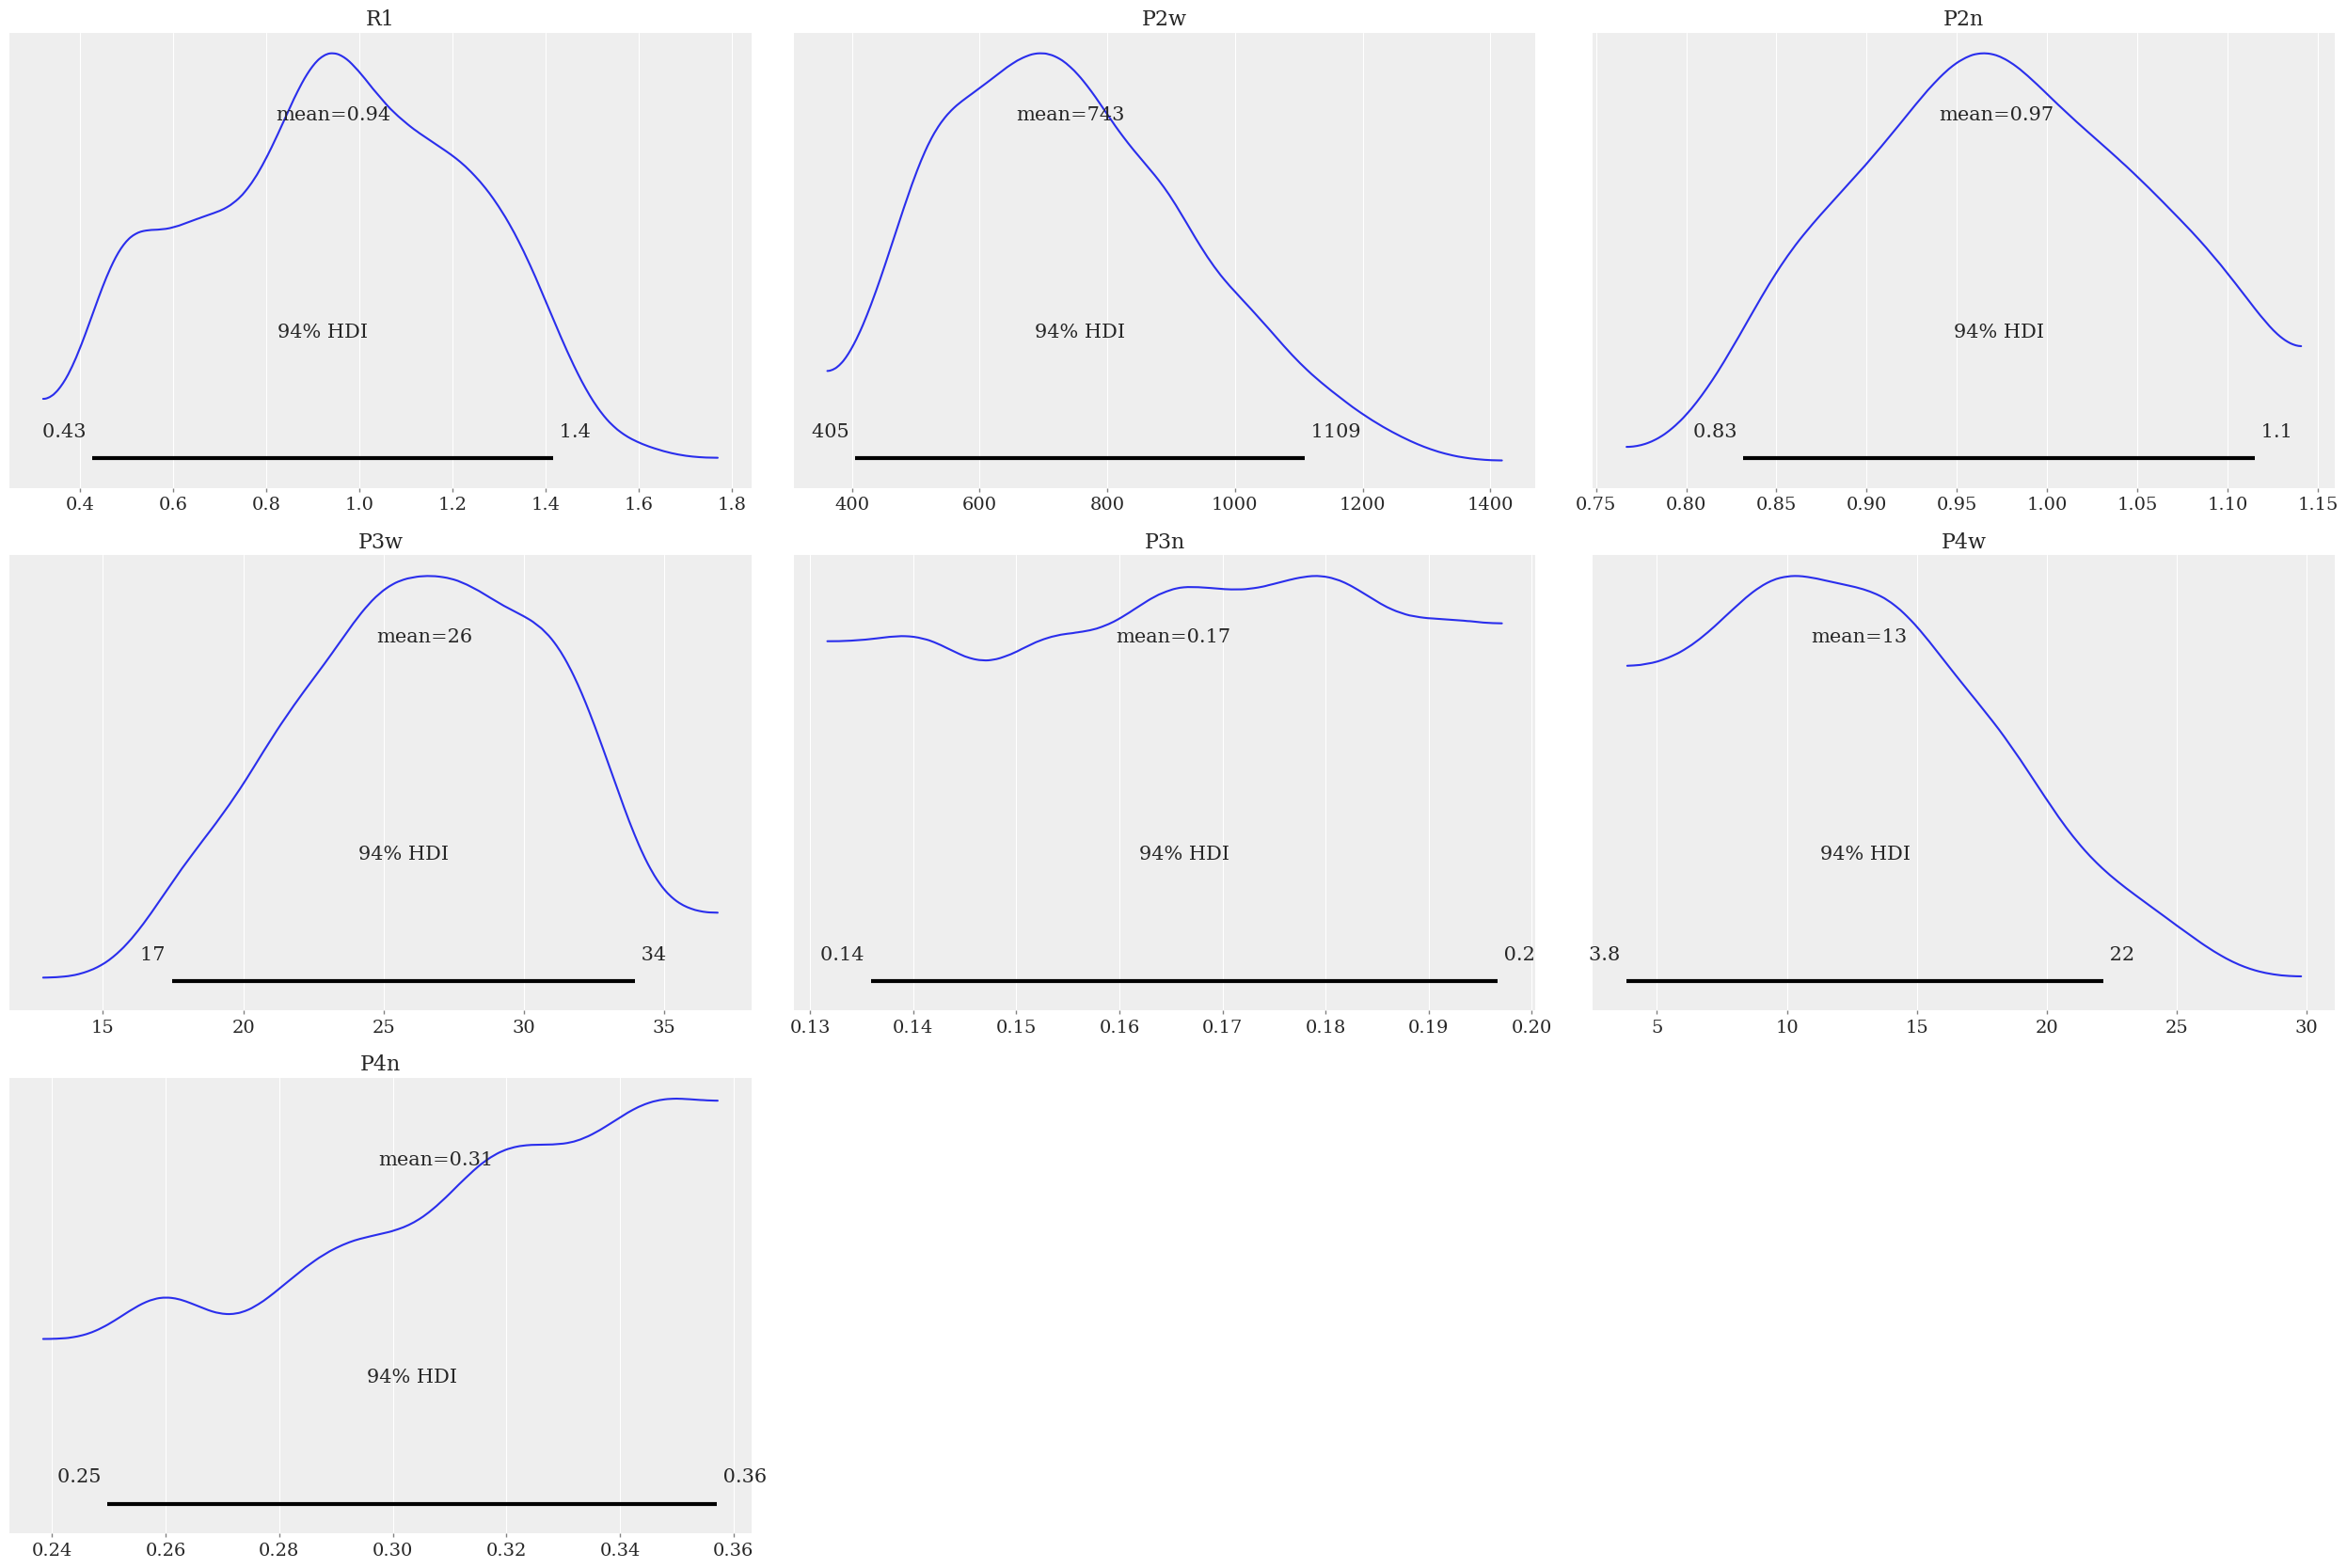

R1-[P2,P3]-P4:Posterior distributions with trajectories


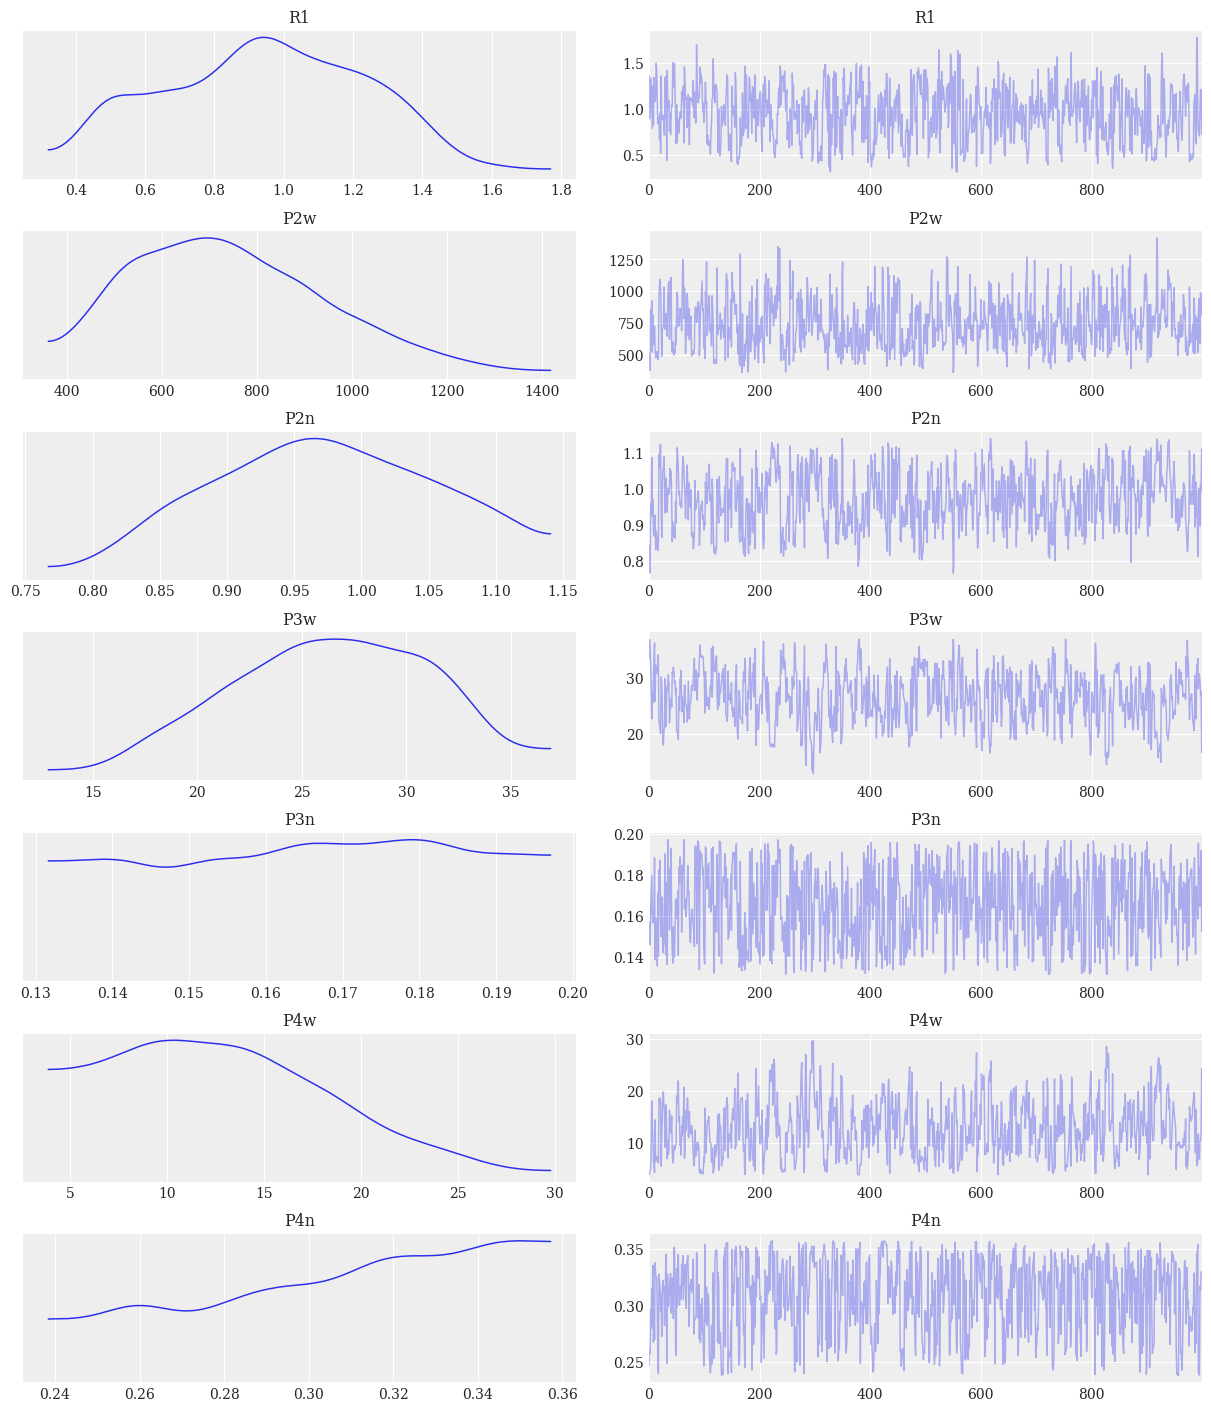

R1-[P2,P3]-P4:Posterior predictions


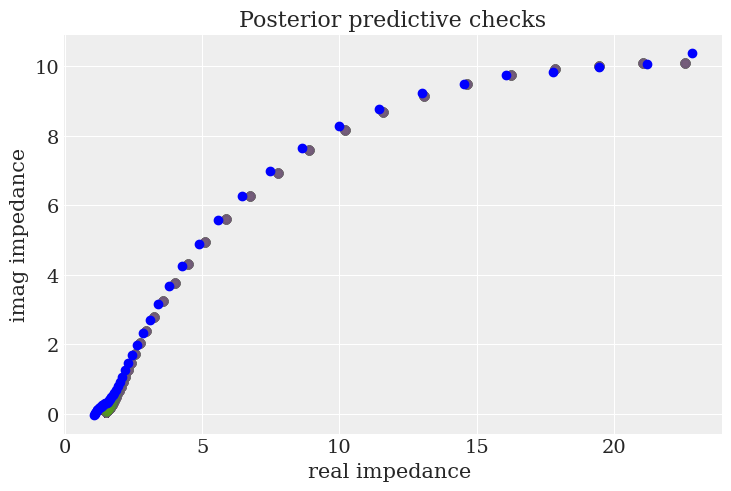

Circuit 4:[[P1,R2],P3-R4]-R5 composed of components (['P1w', 'P1n', 'R2', 'P3w', 'P3n', 'R4', 'R5']) with values ([177.4929, 0.6375, 39.6049, 4.4845, 0.1038, 827019937.3598, 1.2304])


sample: 100%|██████████████████████████| 1500/1500 [00:08<00:00, 170.62it/s, 31 steps of size 1.46e-01. acc. prob=0.95]


[[P1,R2],P3-R4]-R5:Prior distributions with trajectories


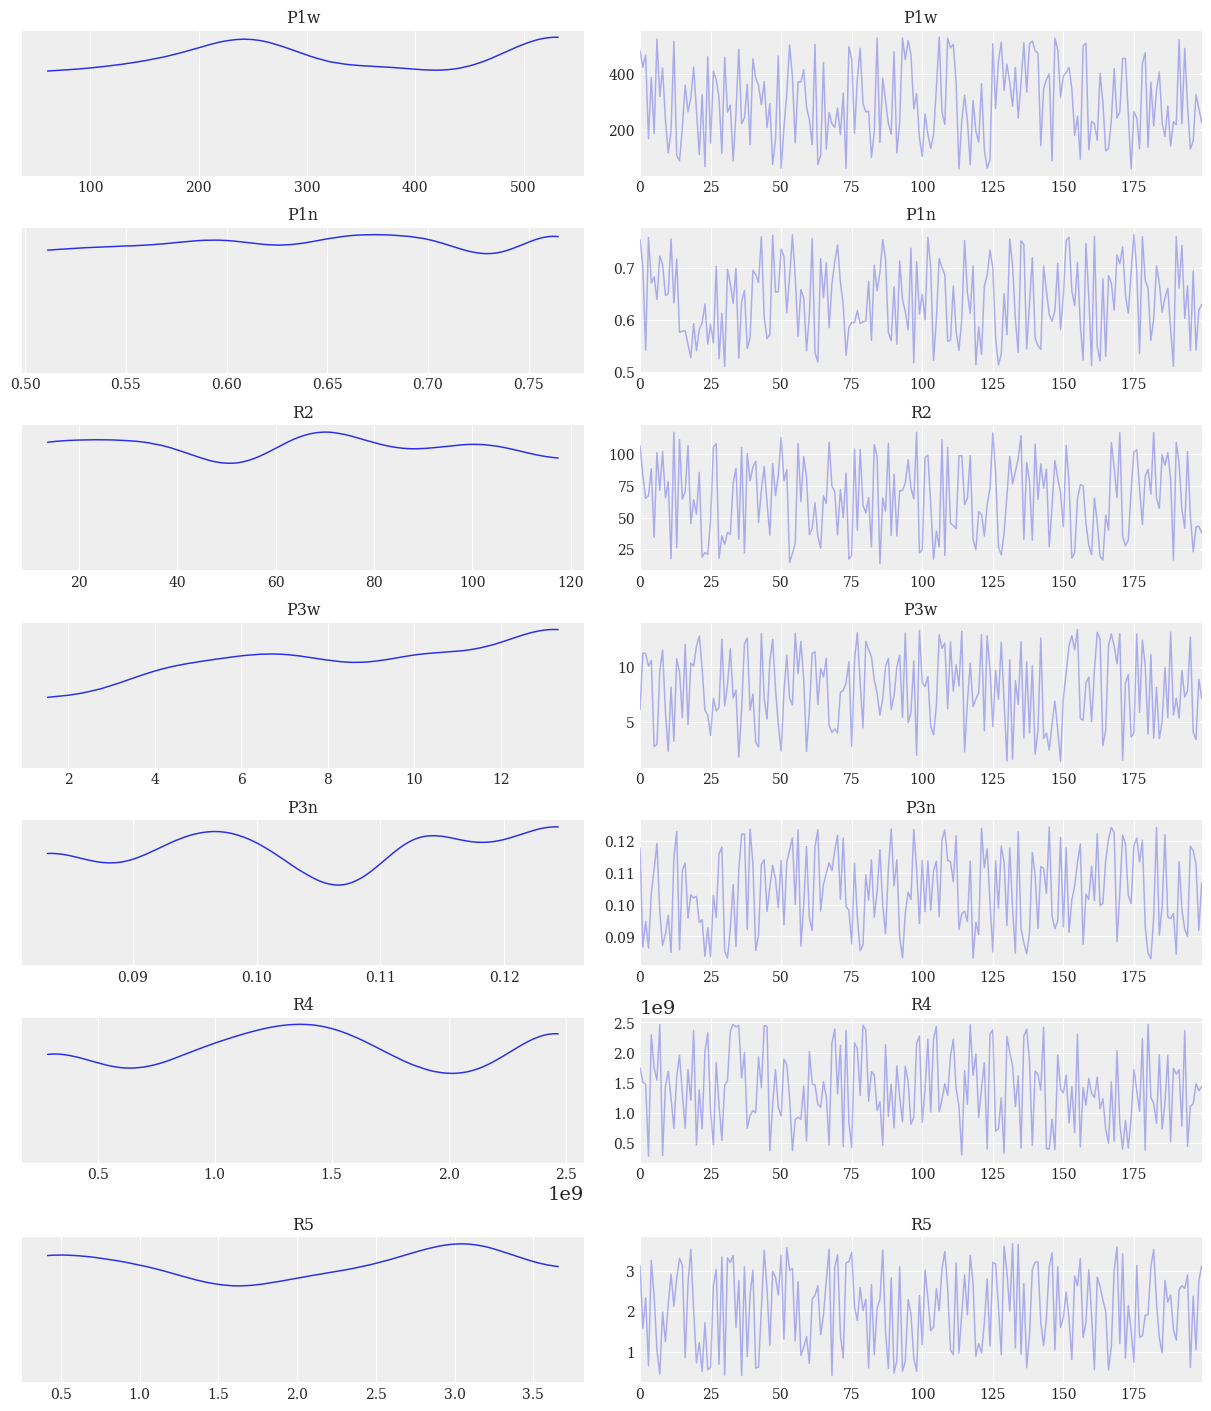

[[P1,R2],P3-R4]-R5:Prior prediction


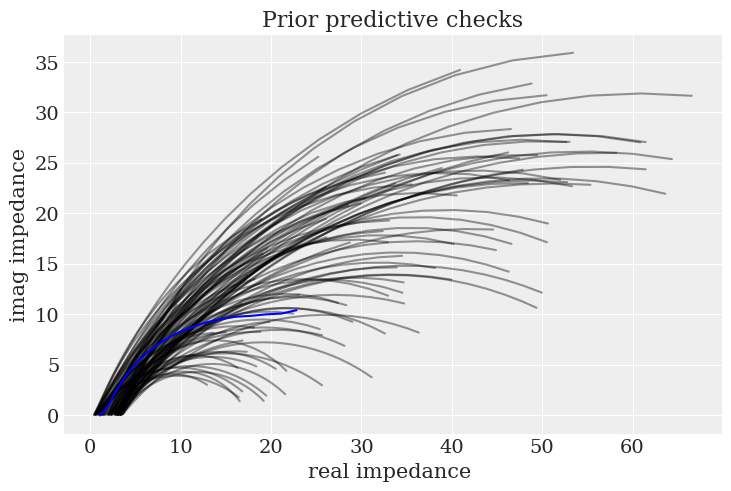

[[P1,R2],P3-R4]-R5:Posterior distributions with HDI


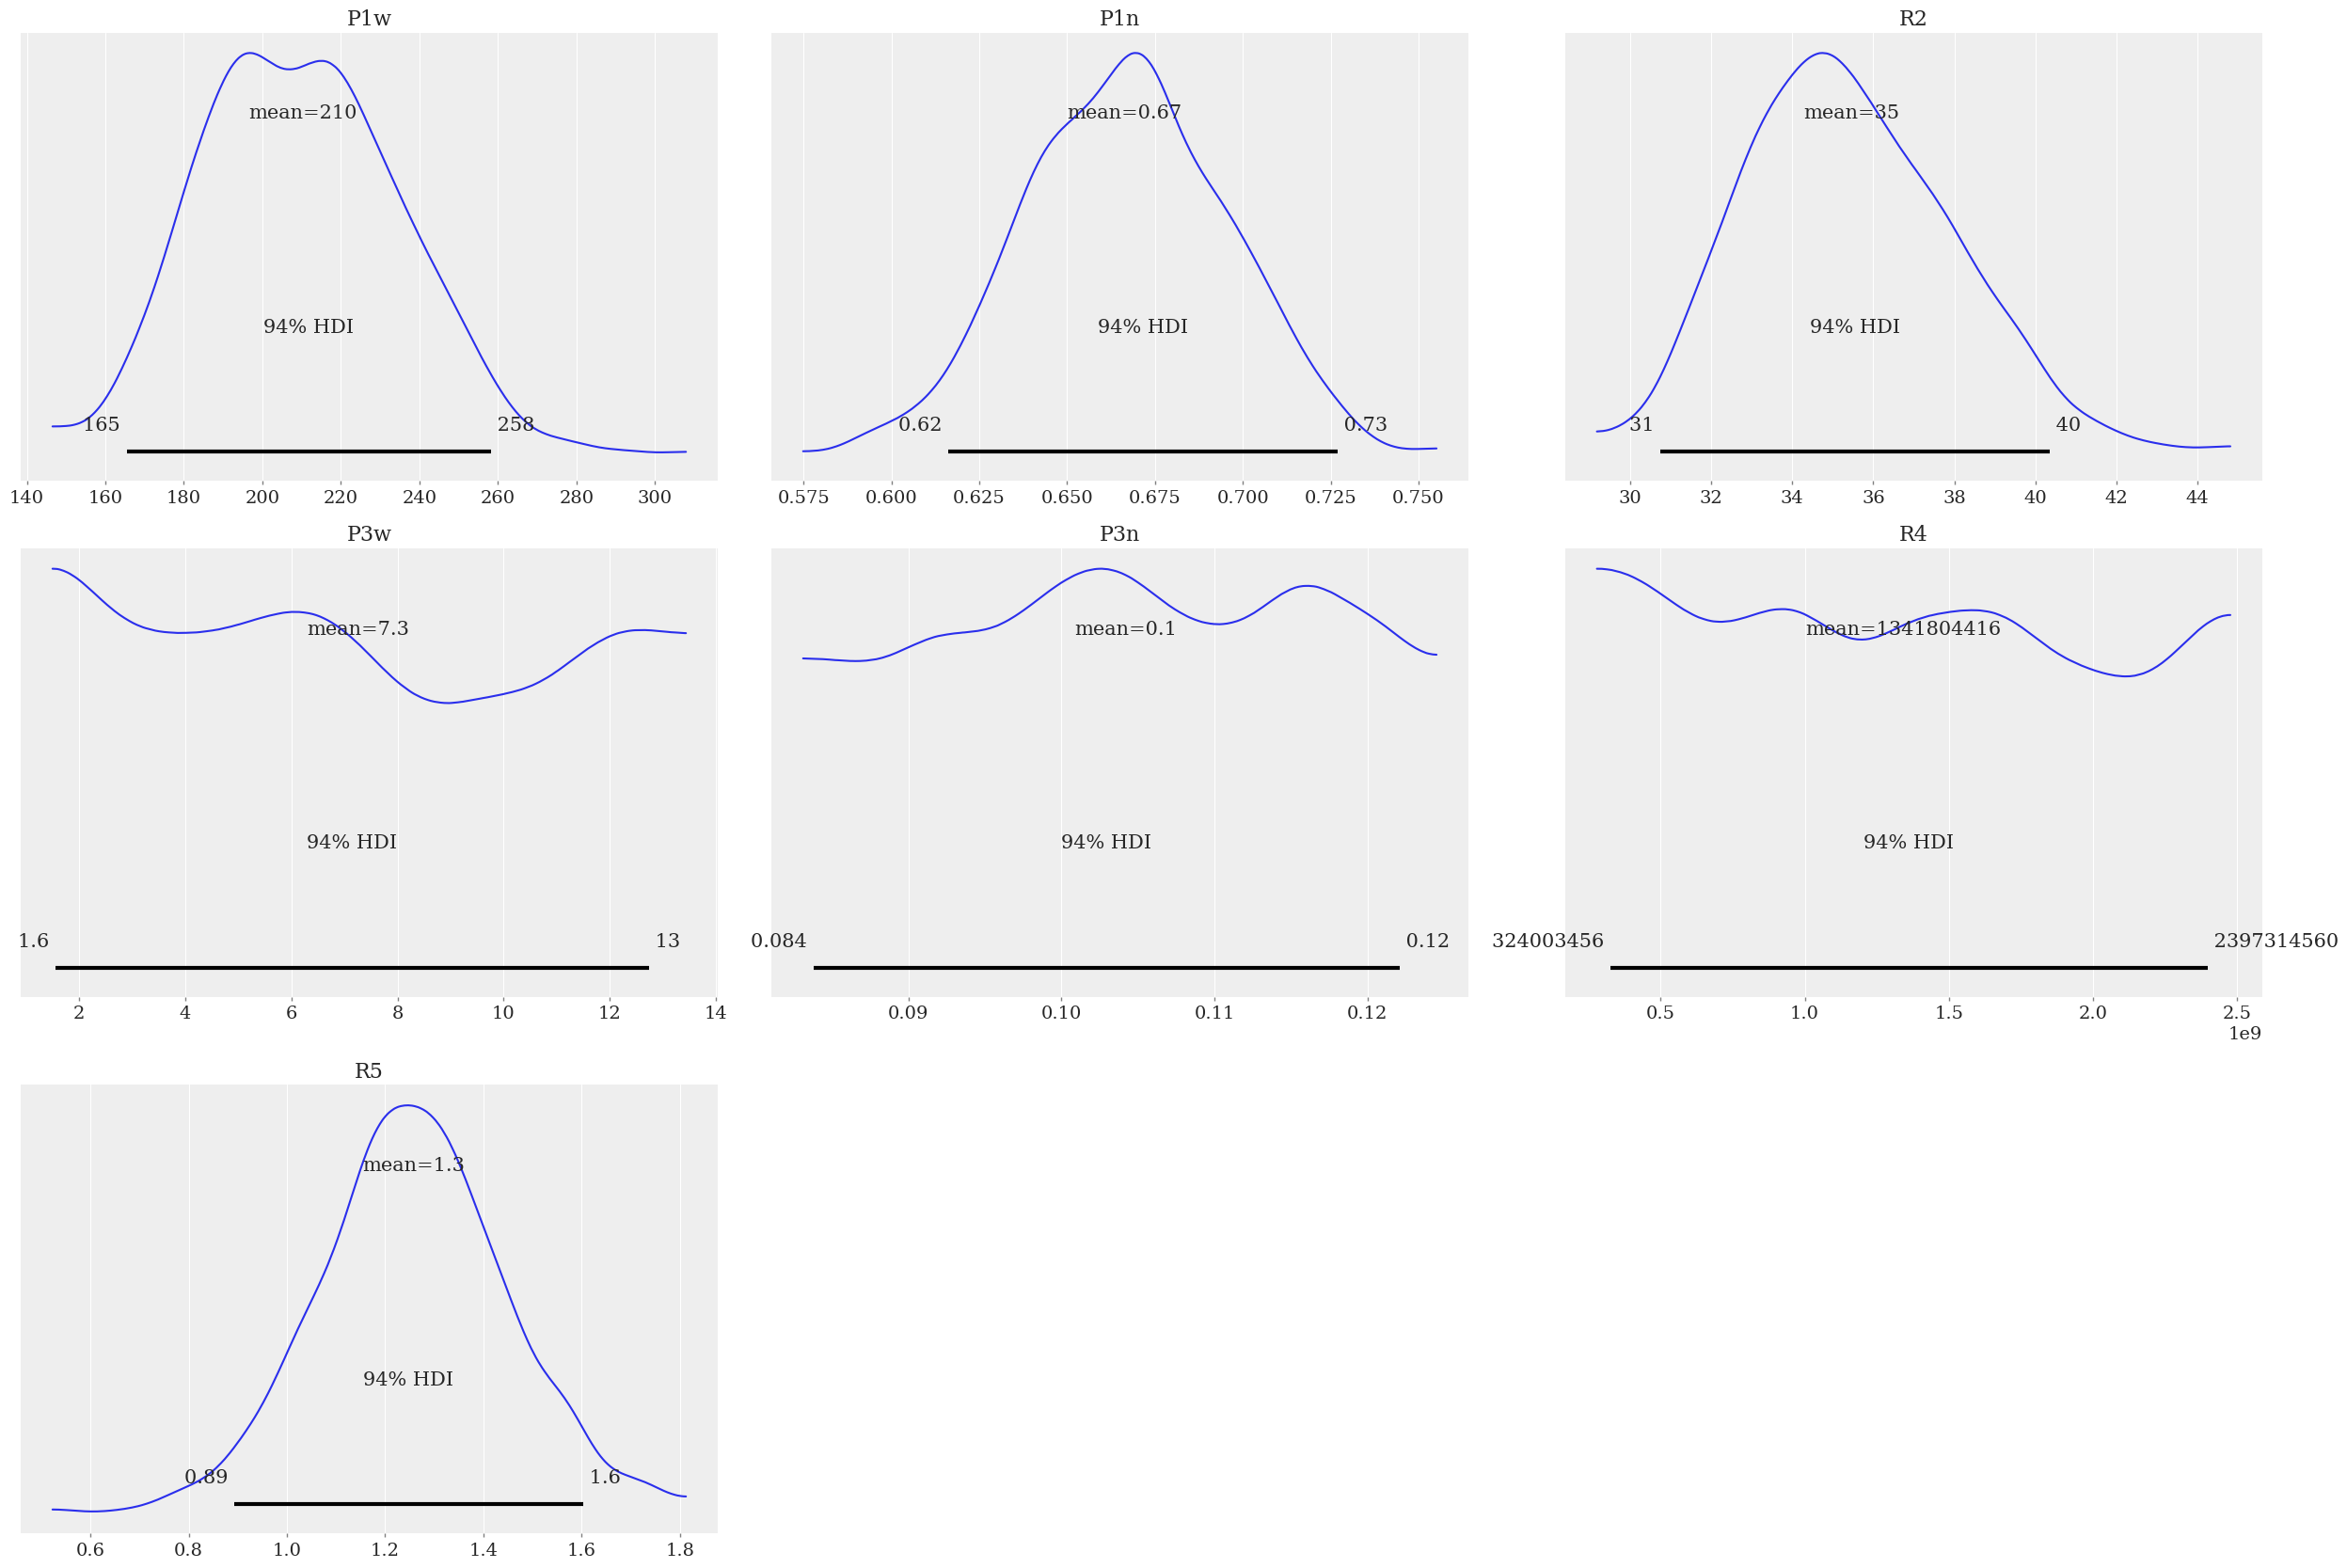

[[P1,R2],P3-R4]-R5:Posterior distributions with trajectories


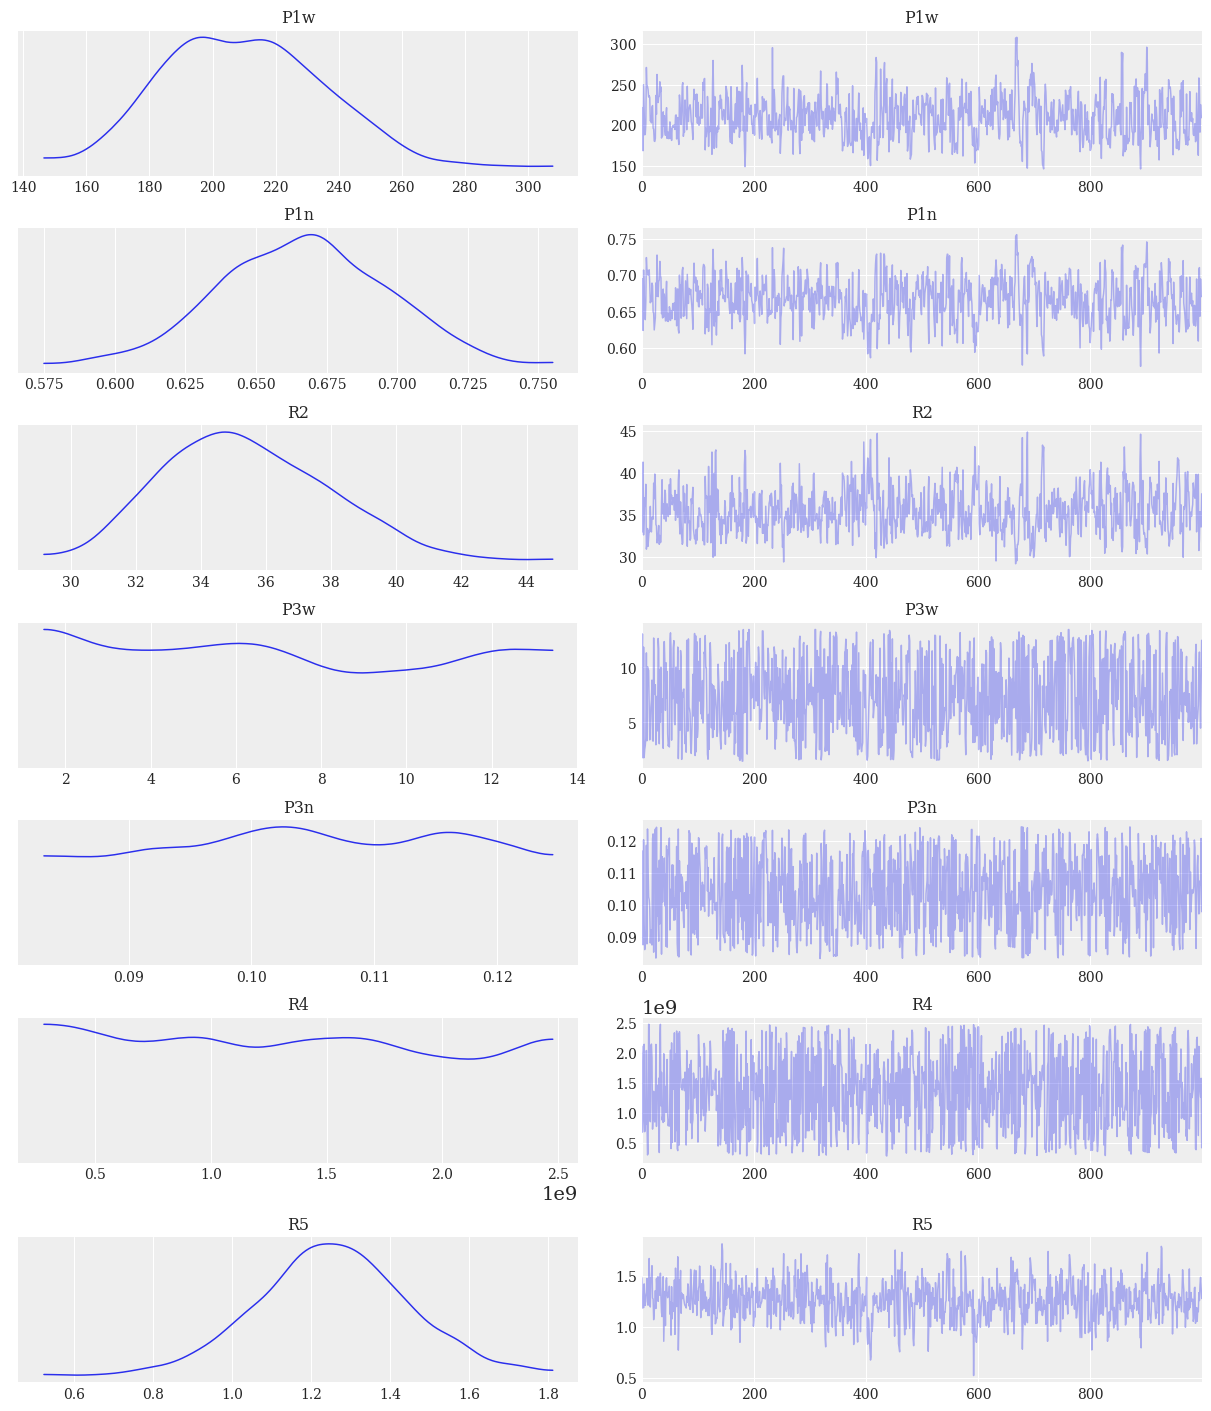

[[P1,R2],P3-R4]-R5:Posterior predictions


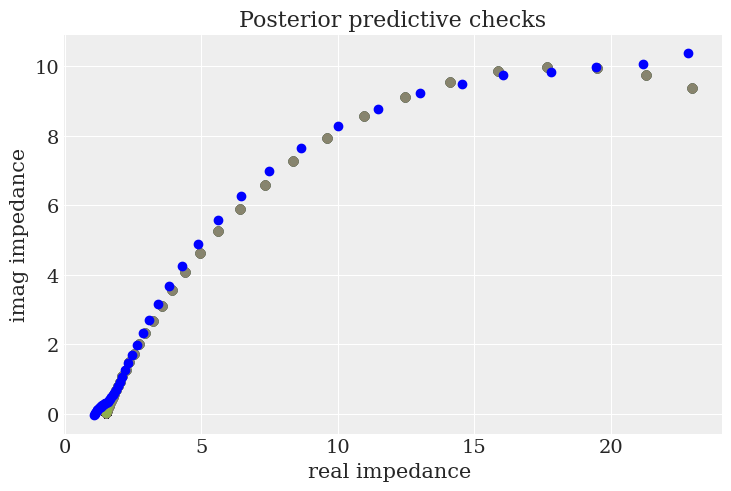

In [48]:
results = ECMs_fitting(impedance = measurements, freq = frequencies, data_path = data_path)

# Function defined board

## Data loading parts

In [5]:
def load_data(data_path):
    
    """ Load the required EIS data(impedance and frequency) from a given data path
        
        Parameter
        ---------
        data_path: str
            the data path of the given EIS data
        
        Returns
        --------
        df: pd.DataFrame
            the dataframe of the given EIS data
    """
    
    data = data_path
    f = open(data)
    if data.endswith(".json"):
        data = json.load(f)
        df = pd.DataFrame(data)
    elif data.endswith(".csv"):
        df = pd.read_csv(f)
    elif data.endswith(".txt"):
        with open("data", "r", encoding="utf-8") as f:
            data = f.read().splitlines()
        # ! modification required
    elif data.endswith(".xlsx"):
        df = pd.read_excel(data)
    return df

In [6]:
def plot_EIS(freq,impedance = "",reals = "",imags = ""):
# 最后定义一个/ style = "default"/ BODE图需要phase

    """ Plot impedance data as nyquist plot and bode plots using matplotlib
    
        Parameters
        ----------
        freq: np.array of floats
            the frequencies of EIS data points
            
        impedance: np.array of complex numbers
            the impedance data
            
        reals: np.array of floats
            the real part of the impedance data
            
        imags: np.array of floats
            the imag part of the impedance data
            
        Returns
        ----------
        No returns
    """

    if impedance != "":
        reals = impedance.real
        imags = impedance.imag
    
    #Set plotting parameters for the non-filtered data
    fig,axes = plt.subplots(1,3,figsize=(15,3.5),dpi=300)

    axes[0].scatter(reals,-imags,s=1.5)
    axes[0].set_xlabel(r'$Re(Z) / \Omega$')
    axes[0].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[0].set_title('Nyquist plot')
    
    axes[1].scatter(freq,reals,s=1.5)
    axes[1].set_xscale('log')
    axes[1].set_xlabel('freq (Hz)')
    axes[1].set_ylabel(r'$Re(Z) / \Omega$')
    axes[1].set_title('Bode plot - real part')
    
    axes[2].scatter(freq,-imags,s=1.5)
    axes[2].set_xscale('log')
    axes[2].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[2].set_xlabel('freq (Hz)')
    axes[2].set_title('Bode plot - imaginary part')
    plt.show()

## Pre-processing parts 
### (pre-process + kk validation (contributed by Robert Black) + extract ohmic resistance

In [7]:
def find_ohmic_resistance(reals,imags):
    
    """ Extract the ohmic resistance of impedance data by doing a 5th order polynomial fit (with 0.05 buffer accuracy)
        
        Parameters:
        ----------
        reals: np.array of floats
            the real part of the impedance data
            
        imags: np.array of floats
            the imag part of the impedance data
            
        Return:
        -------
        ohmic_resistance: float
            the ohmic resistance of impedance data
    """
    
    z = np.polyfit(reals[0:20],imags[0:20],5)
    fz = np.poly1d(z)
    x = symbols('x')
    ohmic_r_set = np.array(list(solveset(fz(x),x,domain=S.Reals)))
    pos = np.where(-imags >= 0 )
    index, = np.where(abs(imags[pos]) == abs(imags[pos]).min()) #finds minimum phase value, note returns as a tuple
    ohmic_resistance = ohmic_r_set[np.where(ohmic_r_set < reals[index]*1.05)].max()
    return ohmic_resistance

In [9]:
def pre_processing(impedance,freq,threshold):
    
    """ Pre-process impedance data by deleting data with positive imaginary part at high-freq range, and by kk validation
        
        Parameters:
        ----------
        impedance: np.array of complex numbers
            the impedance data
            
        freq: np.array of float
            the frequencies of EIS data points
            
        threshold: float
            the parameter that controls the filtering effect of KK validation
            
        Returns:
        --------
        Zdf_mask: pd.DataFrame with 3 columns
            the impedance data after pre-processing
            
        ohmic_resistance: float
            the ohmic resistance of impedance data
    """
    
    # set plotting params and data directory
    tick_size = 9
    label_size = 11

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    plt.rcParams['xtick.labelsize'] = tick_size
    plt.rcParams['ytick.labelsize'] = tick_size
    plt.rcParams['axes.labelsize'] = label_size
    plt.rcParams['legend.fontsize'] = tick_size - 1
    
    # load the data
    Re_Z = impedance.real
    Im_Z = impedance.imag
    # Set plotting parameters for the non-filtered data
    fig,axes = plt.subplots(1,3,figsize=(15,3.5),dpi=300)
    
    # Plot the non-filtered plots
    axes[0].scatter(Re_Z,-Im_Z,s=1.5)
    axes[0].set_xlabel(r'$Re(Z) / \Omega$')
    axes[0].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[0].set_title('Non-filtered')
    axes[1].scatter(freq,Re_Z,s=1.5)
    axes[1].set_xscale('log')
    axes[1].set_xlabel('freq (Hz)')
    axes[1].set_ylabel(r'$Re(Z) / \Omega$')
    axes[1].set_title('Non-filtered')
    axes[2].scatter(freq,-Im_Z,s=1.5)
    axes[2].set_xscale('log')
    axes[2].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[2].set_xlabel('freq (Hz)')
    axes[2].set_title('Non-filtered')
    plt.show()

    ### FILTER 1 - High Frequency Region
    ### Find index where phase_Zwe == minimum, remove all high frequency values below zero
    # find index: 1khz - 100khz
    
    pos = np.where((1000<= frequencies)&(frequencies<= 1000000))
    index, = np.where(abs(Im_Z[pos]) == abs(Im_Z[pos]).min()) #finds minimum phase value, note returns as a tuple
    mask_phase = [True]*len(Im_Z)
    for i in range(len(Im_Z)):
        if i < index:
            mask_phase[i] = False

    freq = freq[index[0]:]
    Z = impedance[index[0]:]
    Re_Z = Re_Z[index[0]:]
    Im_Z = Im_Z[index[0]:]
    
        
    ### FILTER 2 - Low Frequency Region
    ### Lin-KK data validation to remove 'noisy' data
    ### For Lin-KK, the residuals of Re(Z) and Im(Z) are what will be used as a filter. I have found based on the data set that
    ### somewhere ~0.05% works the best
    M, mu, Z_linKK, res_real, res_imag = linKK(freq, Z, c=.5, max_M=100, fit_type='complex', add_cap=True)

    # Plot residuals of Lin-KK for visualization purposes. 
    plt.plot(freq, res_imag, label = 'delta Im')
    plt.plot(freq, res_real, label = 'delta Re')
    plt.xlabel('freq (Hz)')
    plt.ylabel('Delta %')
    plt.xscale('log')
    plt.title('Link-KK Validation')
    plt.legend()
    
    # Need to set a threshold limit for when to filter out the noisy data of the residuals
    # threshold = 0.05 # USER DEFINE!!!

    mask = [False]*(len(res_imag))
    for i in range(len(res_imag)):
        if res_imag[i] < threshold:
            mask[i] = True
        else:
            break

    freq_mask = freq[mask]
    Z_mask = Z[mask]
    Re_Z_mask = Re_Z[mask]
    Im_Z_mask = Im_Z[mask]
    
    # find the ohmic resistance
    ohmic_resistance = find_ohmic_resistance(Re_Z_mask,Im_Z_mask)
    print(f"ohmic_resistance = {ohmic_resistance}")

    #Putting into a dataframe for use with plotting and program
    values_mask = np.array([freq_mask,Re_Z_mask,Im_Z_mask])
    labels = ['freq','Zreal','Zimag']
    Zdf_mask = pd.DataFrame(values_mask.transpose(), columns = labels)
    
    # Plot the data to see how the filter performed
    fig,axes = plt.subplots(1,3,figsize=(15,3.5),dpi=300)
    axes[0].scatter(Zdf_mask['Zreal'].values,-Zdf_mask['Zimag'].values,s=1.5)
    if index == 0:
        axes[0].scatter(Re_Z_mask, fz(Re_Z_mask),s=1.5,c='r')
    axes[0].set_xlabel(r'$Re(Z) / \Omega$')
    axes[0].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[0].set_title('Nyquist Plot')
    axes[1].scatter(Zdf_mask['freq'].values,Zdf_mask['Zreal'].values,s=1.5)
    axes[1].set_xscale('log')
    axes[1].set_xlabel('freq (Hz)')
    axes[1].set_ylabel(r'$Re(Z) / \Omega$')
    axes[1].set_title('Bode plot - Real part')
    axes[2].scatter(Zdf_mask['freq'].values,-Zdf_mask['Zimag'].values,s=1.5)
    axes[2].set_xscale('log')
    axes[2].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[2].set_xlabel('freq (Hz)')
    axes[2].set_title('Bode plot - Imaginary Part')
    plt.show()
    
    return Zdf_mask,ohmic_resistance


In [10]:
def save_processed_data(input_name, data_stored):
    
    """ Store the processed EIS data in a .csv file
        
        Parameters:
        -----------
        input_name: str
            the data path of the given EIS data
            
        data_stored: pd.DataFrame
            the impedance data after pre-processing
        
        Returns:
        --------
        file_name:
            the data path of the processed EIS data
    """
    
    if input_name.endswith(".json"):
        file_name = input_name.split(".json")[0]
    elif input_name.endswith(".csv"):
        file_name = input_name.split(".csv")[0]
    elif input_name.endswith(".txt"):
        file_name = input_name.split(".txt")[0]
    elif input_name.endswith(".xlsx"):
        file_name = input_name.split(".xlsx")[0]
    data_stored.to_csv(file_name+'_processed'+".csv",header = None,index=False)
    data_stored.to_csv('temp'+".csv",header = None,index=False)
    return file_name + ".csv"

## Load the results

In [11]:
def load_results(file_path):
    
    """ load the ECMs results generated by the julia program and convert it to pd.DataFrame
        
        Parameters:
        -----------
        file_path: str
            the file path of ECMs results
            
        Returns:
        --------
        df_circuits: pd.DataFrame
            the dataframe that stored ECMs results generated by the julia program (2 columns)
    """
    
    df_circuits = pd.read_csv(file_path)
    return df_circuits

In [12]:
def split_components(df_circuits):
    
    """ Split all the components and their corresponding values of each ECMs
    
        Parameter:
        ---------
        df_circuits: pd.DataFrame
            the dataframe that stored ECMs results generated by the julia program (2 columns)
            
        Return:
        -------
        df_circuits: pd.DataFrame
            the dataframe that stored ECMs results generated by the julia program (6 columns)
    """
    
    # define some regular expression pattern to separate each kind of elements
    resistor_p = re.compile(r'[R][0-9][a-z]? = [0-9]*\.[0-9]*')
    capacitor_p = re.compile(r'[C][0-9][a-z]? = [0-9]*\.[0-9]*')
    inductor_p = re.compile(r'[L][0-9][a-z]? = [0-9]*\.[0-9]*')
    CPE_p = re.compile(r'[P][0-9][a-z]? = [0-9]*\.[0-9]*')

    # initialize some lists to store the values of each kind of elements
    resistors_list = []
    capacitors_list = []
    inductors_list = []
    CPEs_list = []

    for i in range(len(df_circuits['Parameters'])):
        resistors = resistor_p.findall(df_circuits['Parameters'][i])
        capacitors = capacitor_p.findall(df_circuits['Parameters'][i])
        inductors = inductor_p.findall(df_circuits['Parameters'][i])
        CPEs = CPE_p.findall(df_circuits['Parameters'][i])

        resistors_list.append(resistors)
        capacitors_list.append(capacitors)
        inductors_list.append(inductors)
        CPEs_list.append(CPEs)

    df_circuits['Resistors'] = resistors_list
    df_circuits['Capacitors'] = capacitors_list
    df_circuits['Inductors'] = inductors_list
    df_circuits['CPEs'] = CPEs_list
    
    return df_circuits

## Filtering the results with constraint reasonings

In [13]:
def capacitance_filter(df_circuits):
    
    """ Filter the circuits by ideal capacitors
        
        Parameter:
        ----------
        df_circuits: pd.DataFrame
           the dataframe that stored ECMs results generated by the julia program (6 columns)
           
        Return:
        -------
        df_circuits: pd.DataFrame
           the dataframe that stored ECMs results (without ideal capacitors) generated by the julia program (6 columns)
    """
    
    for i in range(len(df_circuits['Capacitors'])):
        if df_circuits['Capacitors'][i] != []:
            df_circuits.drop([i],inplace = True)
    df_circuits.reset_index(drop=True,inplace=True)
    return df_circuits

In [14]:
def find_series_elements(circuit):
    
    """ Extract the series componenets existed in the circuit
    
        Parameter:
        ----------
        circuit: str
            the string that stores the configuration of a given circuit
        
        Return:
        -------
        series_circuit: str
            the string that stores the series parts of a given circuit
    """
    
    series_circuit = []
    identifior = 0
    for i in range(len(circuit)):
        if circuit[i] == '[':
            identifior += 1
        if identifior == 0:
            series_circuit.append(circuit[i])
        if circuit[i] == ']':
            identifior -= 1
        # elif identifior != 0:
        #    index_list.append([False])
    series_circuit = ''.join(series_circuit)
    return series_circuit

In [43]:
def ohmic_resistance_filter(df_circuits, ohmic_resistance):
    
    """ Extract the ohmic resistance of each circuit and filter the circuits according to the values (with 15% buffer)
        
        Parameter:
        ----------
        df_circuits: pd.DataFrame
           the dataframe that stored ECMs results (without ideal capacitors) generated by the julia program (6 columns)
        
        ohmic_resistance: float
            the ohmic resistance of the given EIS data
            
        Return:
        -------
        df_circuits: pd.DataFrame
           the dataframe that stored ECMs results (without ideal capacitors/with correct ohmic resistance) generated by the julia program (6 columns)

            
    """
    
    for i in range(len(df_circuits['Circuit'])):
        # find the series elements
        series_circuit = find_series_elements(circuit = df_circuits['Circuit'][i])
        # find the series resistors
        find_R = re.compile(r'R[0-9]')
        series_resistors = find_R.findall(series_circuit)
        # initiate a list to store series resistors' values for future comparison
        R_values_list = []
        for j in range(len(series_resistors)):
            value_R_p = re.compile(f'{series_resistors[j]} = [0-9]*\.[0-9]*')
            values_R_withid = value_R_p.findall(''.join(df_circuits['Resistors'][i]))
            value_R_p2 = re.compile(r'[0-9]*\.[0-9]*')
            for k in range(len(values_R_withid)):
                R_value = value_R_p2.findall(values_R_withid[k])
                R_values_list.append(R_value)
        if R_values_list == []:
            df_circuits.drop([i],inplace = True)
        else:
            value_identify_list = []
            for m in range(len(R_values_list)):
                if float(R_values_list[m][0]) < ohmic_resistance * 0.85 or float(R_values_list[m][0]) > ohmic_resistance * 1.15:
                    value_identify_list.append(False)
                else:
                    value_identify_list.append(True)
            if True not in value_identify_list:
                df_circuits.drop([i],inplace = True)

    df_circuits.reset_index(drop=True,inplace=True)
    return df_circuits

## Generate mathematical expression

In [16]:
def generate_mathematical_expression(df_circuits):
    
    """ Generate the mathematical expression of each circuit
        
        Parameter:
        ----------
        df_circuits: pd.DataFrame
           the dataframe that stored ECMs results (without ideal capacitors/with correct ohmic resistance) generated by the julia program (6 columns)
        
        Return:
        -------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (7 columns)

    """
    
    # define two kinds of pattern to find all elements in the circuit
    test_pattern = re.compile(r'([CLRP])([0-9])+')
    test_pattern_2 = re.compile(r'[CLRP][0-9]')
    
    # create a list to store the mathematical expressions
    new_circuits = []
    
    for i in range(len(df_circuits['Circuit'])):
        circuit = df_circuits['Circuit'][i]
        for j,k in zip(["-","[",",","]"],["+","((",")**(-1)+(",")**(-1))**(-1)"]):
            circuit = circuit.replace(j,k)
        test_results = test_pattern.findall(circuit)
        test_results_2 = test_pattern_2.findall(circuit)
        
        for m in range(len(test_results)):
            if test_results[m][0] == 'R':
                circuit = circuit.replace(test_results_2[m],"X")
            elif test_results[m][0] == 'C':
                circuit = circuit.replace(test_results_2[m],"(1/(2*1j*np.pi*F*X))")
            elif test_results[m][0] == 'L':
                circuit = circuit.replace(test_results_2[m],"(2*1j*np.pi*F*X)")
            elif test_results[m][0] == 'P':
                circuit = circuit.replace(test_results_2[m],"X*(2*np.pi*F)**(-Y)*(np.cos((np.pi*Y)*0.5)-np.sin((np.pi*X)*0.5)*1j)")
        
        new_temp_circuit = []
        counter = 0
        
        for n in range(len(circuit)):
            if circuit[n] == 'X':
                new_temp_circuit.append(f"X[{str(counter)}]")
                counter += 1
            elif circuit[n] == 'Y':
                new_temp_circuit.append(f"X[{str(counter)}]")
            else:
                new_temp_circuit.append(circuit[n])
        new_circuit = ''.join(new_temp_circuit)
        new_circuits.append(new_circuit)
        

    df_circuits['Mathematical expressions'] = new_circuits
    
    return df_circuits
 

## Extract the features of each circuit

In [17]:
def s_to_a_convert(circuit):
    
    """ Convert the circuit configuration strings to np.array (representing components by numbers)
        
        Parameter:
        ----------
        circuit: str
            the string that stores the circuit configurations
            
        Return:
        -------
        circuit_array: np.array
            the nparray that stores the circuit configurations
    """
    
    # delete the numbers included in str
    circuit = re.sub(r'[0-9]+', '', circuit)
    pat = re.compile(r'[RCLP\[\]\-,]')
    str = pat.findall(circuit)
    circuit_array = np.zeros((1,len(str)))
    for i in range(len(str)):
        # encoding rules: R=1，C=2，L=3，P=4，[=5,]=6,"-"=7,","=8
        if str[i] == "R":
            circuit_array[0,i] = 1
        elif str[i] == "C":
            circuit_array[0,i] = 2
        elif str[i] == "L":
            circuit_array[0,i] = 3
        elif str[i] == "P":
            circuit_array[0,i] = 4
        elif str[i] == "[":
            circuit_array[0,i] = 5
        elif str[i] == "]":
            circuit_array[0,i] = 6
        elif str[i] == "-":
            circuit_array[0,i] = 7
        elif str[i] == ",":
            circuit_array[0,i] = 8
    return circuit_array[0]

In [18]:
def count_components(circuit,symbols = True):
    
    """ Calculate the numbers of each kind of component in given circuit strings (R/C/L/P/-/,/[/])
        
        Parameters:
        -----------
        circuit: str
            the string that stores the circuit configurations
            
        symbols: bool
            the bool number that decides whether to count the number of connectors in given circuit strings (-/,/[/])
            
        Return:
        -------
        array_components_numbers:np.array
            the array that stores the number of each kind of component 

    """
    
    # define the pattern for each components (p denotes pattern)
    r_p = re.compile(r'[R]')
    c_p = re.compile(r'[C]')
    l_p = re.compile(r'[L]')
    p_p = re.compile(r'[P]')
    if symbols:
        b_p = re.compile(r'[\[\]]')
        d_p = re.compile(r'[\-]')
        comma_p = re.compile(r'[,]')
    
    # find the individual components (n denotes number)
    r_n = r_p.findall(circuit) 
    c_n = c_p.findall(circuit)
    l_n = l_p.findall(circuit)
    p_n = p_p.findall(circuit)
    if symbols:
        b_n = b_p.findall(circuit)
        d_n = d_p.findall(circuit)
        comma_n = comma_p.findall(circuit)
    
    # create array to store the numbers of components
    if symbols:
        array_components_numbers = np.zeros((1,7))
    else:
        array_components_numbers = np.zeros((1,4))
        
    # store the numbers of components into array
    array_components_numbers[0,0] = len(r_n)
    array_components_numbers[0,1] = len(c_n)
    array_components_numbers[0,2] = len(l_n)
    array_components_numbers[0,3] = len(p_n)
    if symbols:
        array_components_numbers[0,4] = len(b_n) # /2 can be used to find the number of separated parallel structure
        array_components_numbers[0,5] = len(d_n)
        array_components_numbers[0,6] = len(comma_n) # add this number with the number of separated parallel sturcture can get the number of subcircuits 
        
    return array_components_numbers[0]

In [19]:
def rank_the_structure(circuit_array):
    
    """ Rank each component in given circuits according to its 'complexity' (defined by how many parallel structures it's in)
    
        Parameter:
        ----------
        circuit_array: np.array
            the nparray that stores the circuit configurations
        
        Return:
        -------
        ranks_array: np.array
            the nparray that stores the level information of given circuits
    """
    
    ranks_array = np.zeros([1,len(circuit_array)])
    ranker = 0
    for i in range(len(circuit_array)):
        if circuit_array[i] == 5:
            ranker += 1
            # -1: [
            ranks_array[0,i]= -1 
        # elif circuit_array[i] == 8:
        #    ranker += 0.5
        #    ranks_store[0,i] = -3
            # -3: ,
        elif circuit_array[i] == 6:
            ranker -= 1
            ranks_array[0,i] = -2
        else:
            ranks_array[0,i] = ranker
    return ranks_array[0]

In [20]:
def structure_deconstructor(ranks_array):
    
    """ Extract the index information of each level circuit according to ranking array
        
        Parameter:
        ----------
        ranks_array:np.array
            the nparray that stores the level information of given circuits
        
        Return:
        -------
        indexs_lists: list
            the list that stores the index information of each level circuit
    """

    # initialize a list to store the indexs 
    indexs_list = []
    # initialize a list to store the index lists
    indexs_lists = []
    for i in range(len(ranks_array)):
        if ranks_array[i] < 0:
            indexs_lists.append(indexs_list)
            indexs_list = []
        elif ranks_array[i] >= 1:
            indexs_list.append(i)
    indexs_lists = [x for x in indexs_lists if x != []]
    return indexs_lists

In [21]:
def structure_extractor(circuit_array,ranks_array, indexs_lists):
    
    """ Extract the circuit configuration at each level
        
        Parameters:
        -----------
        circuit_array: np.array
            the nparray that stores the circuit configurations
            
        ranks_array:np.array
            the nparray that stores the level information of given circuits
            
        indexs_lists: list
            the list that stores the index information of each level circuit
            
        Return:
        -------
        characteristic_array: np.array
            the nparray that stores the circuit configuration separated at different levels 
    """
    
    characteristic_array = np.zeros([len(indexs_lists),max(len(index) for index in indexs_lists)+1])
    for i in range(len(indexs_lists)):
        if ranks_array[indexs_lists[i][0]] == 1:
            characteristic_array[i][0] = 1
        elif ranks_array[indexs_lists[i][0]] == 2:
            characteristic_array[i][0] = 2
        elif ranks_array[indexs_lists[i][0]] == 3:
            characteristic_array[i][0] = 3
        elif ranks_array[indexs_lists[i][0]] == 4:
            characteristic_array[i][0] = 4
        elif ranks_array[indexs_lists[i][0]] == 5:
            characteristic_array[i][0] = 5
        else:
            assert ("Error:Circuit's too complex")
            
        segment = np.array(sorted(circuit_array[indexs_lists[i]]))
        characteristic_array[i][1:1+len(segment)] = segment.reshape(1,len(segment))

    sort_list = [characteristic_array[:,i] for i in range(characteristic_array.shape[1])]
    idex = np.lexsort(sort_list)
    
    characteristic_array = characteristic_array[idex,:]
    
    return characteristic_array

In [22]:
def precise_rank_the_structure(circuit_array):
    
    """ Rank each component in given circuits according to its 'complexity' in a more precise way (defined by how many parallel structures it's in)
    
        Parameter:
        ----------
        circuit_array: np.array
            the nparray that stores the circuit configurations
        
        Return:
        -------
        ranks_array: np.array
            the nparray that stores the level information of given circuits
    """
    
    ranks_array = np.zeros([1,len(circuit_array)])
    ranker = 0
    for i in range(len(circuit_array)):
        if circuit_array[i] == 5:
            ranker += 1
            ranker = int(ranker)
            # -1: [
            ranks_array[0,i]= ranker 
        elif circuit_array[i] == 8:
            ranker += 0.1
            # -3: ,
            ranks_array[0,i] = ranker
        elif circuit_array[i] == 6:
            ranker -= 1
            ranker = int(ranker)
            # -2 : ]
            ranks_array[0,i] = ranker
        else:
            ranks_array[0,i] = ranker
    return ranks_array[0]

In [23]:
def precise_extractor(circuit_array,precise_ranks_array):
    
    """ Extract the index information of each level circuit according to ranking array in a more precise way
        
        Parameter:
        ----------
        circuit_array: np.array
            the nparray that stores the circuit configuration
            
        precise_ranks_array:np.array
            the nparray that stores the level information of given circuits
        
        Return:
        -------
        level_lists: list
            the list that stores the index information of each level circuit
    """
    
    level_lists = []
    if circuit_array[0] == 5:
        # detect [
        # print(1,0)
        level_list = []
        level_list.append(int(precise_ranks_array[0]))
        for j in range(0,len(precise_ranks_array)-1):
            if precise_ranks_array[j] > int(precise_ranks_array[j]) and int(precise_ranks_array[j]) == precise_ranks_array[0]:
                # print("1 end:",j)
                level_list.extend(z for z in circuit_array[0+1:j])
                level_lists.append(level_list)
                break
    for i in range(len(precise_ranks_array)-1):
        if int(precise_ranks_array[i+1]) - int(precise_ranks_array[i]) == 1:
            # detect[ 
            # print(1,i)
            level_list = []
            level_list.append(int(precise_ranks_array[i+1]))
            for j in range(i,len(precise_ranks_array)-1):
                if precise_ranks_array[j] > int(precise_ranks_array[j]) and int(precise_ranks_array[j]) == precise_ranks_array[i+1]:
                    # print("1 end:",j)
                    level_list.extend(z for z in circuit_array[i+2:j])
                    level_lists.append(level_list)
                    break
        elif round(precise_ranks_array[i+1] - precise_ranks_array[i],1) == 0.1:
            # detect ","
            # print(2,i)
            level_list = []
            level_list.append(int(precise_ranks_array[i+1]))
            for j in range(i+2,len(precise_ranks_array)):
                if precise_ranks_array[j] > precise_ranks_array[j-1] and int(precise_ranks_array[j]) == int(precise_ranks_array[j-1]) and int(precise_ranks_array[j]) == int(precise_ranks_array[i+1])or precise_ranks_array[j] == int(precise_ranks_array[i]-1):
                    # print("2 end:", j)
                    level_list.extend(z for z in circuit_array[i+2:j])
                    level_lists.append(level_list)
                    break
    return level_lists



In [24]:
def sort_level_lists(level_lists):
    
    """ Sort the level lists:
    
        Parameter:
        ----------
        level_lists:
            the list that stores the index information of each level circuit
            
        Return:
        -------
        level_lists:
            the sorted list that stores the index information of each level circuit

    """
    
    for i in range(len(level_lists)):
        level_lists[i] = sorted(level_lists[i])
    level_lists = sorted(level_lists)
    return level_lists

In [25]:
def feature_store(circuit):
    
    """ Extract the features of given circuits and store them as a dictionary
            Feature 1: the component numbers (R/C/L/P/-/,/[/]) of a given circuit
            Feature 2: the component numbers in series part of a given circuit
            Feature 2.5: the parallel parts of a given circuit at different levels
            Feature 3: the information of all parallel subcircuits
            
        Parameter:
        ----------
        circuit: str
            the string that stores the circuit configuration
            
        Return:
        -------
        characteristic_features: dict
            the dictionary that stores the above 4 characteristics of a given circuit
    """
    
    circuit = circuit
    circuit_array = s_to_a_convert(circuit)
    ranks_array = rank_the_structure(circuit_array)
    indexs_lists = structure_deconstructor(ranks_array)
    precise_ranks_array = precise_rank_the_structure(circuit_array)
    
    # features 1 - the numbers of each kind of element are equal
    components_numbers = count_components(circuit)
    # feature 2 - same series configurations
    series_numbers = count_components(find_series_elements(circuit))
    # feature 2 - same configurations at different parallel levels
    characteristic_array = structure_extractor(circuit_array,ranks_array,indexs_lists)
    # feature 3 - all parallel subcircuit shoule be identical
    level_lists = precise_extractor(circuit_array,precise_ranks_array)
    level_lists = sort_level_lists(level_lists)
    
    # store the features:
    characteristic_features = {}
    characteristic_features['Circuit_Name'] = circuit
    characteristic_features['Feature 1'] = components_numbers
    characteristic_features['Feature 2'] = series_numbers
    characteristic_features['Feature 2.5'] = characteristic_array
    characteristic_features['Feature 3'] = level_lists
    
    return characteristic_features

## Identify the identical circuits and combine them

In [26]:
def identifior(df_circuits):
    
    """ Identfy the identical circuits configurations by the above features
        
        Parameter:
        ----------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (7 columns)
           
        Returns:
        --------
        equal_lists: list
            the list that stores the strings of identical circuit configurations
            
        equal_lists_seq: list
            the list that stores the index of identical circuits
    """
    equal_lists = []
    equal_lists_seq = []
    for i in range(len(df_circuits['Circuit'])):
        feature_i = feature_store(df_circuits['Circuit'][i])
        equal_list = []
        equal_list_seq = []
        for j in range(len(df_circuits['Circuit'])):
            feature_j = feature_store(df_circuits['Circuit'][j])
            # if (feature_i['Feature 1'] == feature_j['Feature 1']).all() and (feature_i['Feature 2'] == feature_j['Feature 2']).all() and (feature_i['Feature 2.5'] == feature_j['Feature 2.5']).all() and feature_i['Feature 3'] == feature_j['Feature 3']:
            if feature_i['Feature 1'].tolist() == feature_j['Feature 1'].tolist() and feature_i['Feature 2'].tolist() == feature_j['Feature 2'].tolist() and feature_i['Feature 2.5'].tolist() == feature_j['Feature 2.5'].tolist() and feature_i['Feature 3'] == feature_j['Feature 3']:
                equal_list.append(df_circuits['Circuit'][j])
                equal_list_seq.append(j)
        equal_lists.append(equal_list)
        equal_lists_seq.append(equal_list_seq)
    return equal_lists, equal_lists_seq  

In [27]:
def filter(similar_circuits):
    
    """ Filter the repeated "identical circuits list" in the list
        
        Parameter:
        ----------
        similar_circuits: list
            the list that stores the index of identical circuits or the strings of identical circuit configurations
        
        Return:
        -------
        equal_list_filtered: list
            the processed list that stores the index of 

    """
    
    similar_circuits.sort()
    equal_list_filtered = list(similar_circuits for similar_circuits,_ in itertools.groupby(similar_circuits))
    return equal_list_filtered

In [28]:
def circuit_expression_combine_lists(df_circuits):
    
        
    """ Identfy the identical circuits configurations by the above features
        
        Parameter:
        ----------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (7 columns)
           
        Returns:
        --------
        similar_expression: list
            the processed list that stores the strings of identical circuit configurations
            
        similar_expression_index: list
            the processed list that stores the index of identical circuits
    """
   
    similar_lists = identifior(df_circuits)
    similar_expression = filter(similar_lists[0])
    similar_expression_index = filter(similar_lists[1])
    
    return similar_expression, similar_expression_index


In [29]:
def component_values(input):
    
    """ Before combination, separate the components names and values for further comparison to identify identical circuit values
    
        Parameter:
        ----------
        df_circuits['Parameters']: pd.Series
            the series that stores the names and values information of a given circuit
        
        Returns:
        --------
        component_values_lists: list
            the list that stores the component values and component names
            
        values_lists: list
            the list that only stores the component values
            
        names_lists: list
            the list that only stores the component names
    """
    
    # delete the ( and ) in the string
    delete_p = re.compile(r'[^()]')
    
    # store the values of each component in 4 digits
    digit_p = re.compile(r'\-?[0-9]+\.[0-9]+e*-*[0-9]*')
    
    # store the names of each component
    name_p = re.compile(r'[A-Z][1-9][a-z]? = ')
    
    # create lists to store these data
    values_lists = []
    component_values_lists =[]
    names_lists =[]
    
    for i in range(len(input)):
        # separate the values of each component and store them with their name together
        # component_values_list = delete_p.findall(input[0])
        # component_values_list = ''.join(component_values_list)
        # component_values_list = component_values_list.split(',')
        # component_values_lists.append(component_values_list)
        
        # store the values of each component
        values_list = digit_p.findall(input[i]) 
        for j in range(len(values_list)):
            values_list[j] = float(values_list[j])
            values_list[j] = ("%.4f"%values_list[j])
            values_list[j] = float(values_list[j])
        values_lists.append(values_list)
        
        # store the names of each component
        names_list = name_p.findall(input[i])
        names_lists.append(names_list)
        
        # combine the names with values
        component_values_list=[]
        for k in range(len(values_list)):
            seq = [names_list[k],str(values_list[k])]
            component_values_list.append(''.join(seq))
        component_values_lists.append(component_values_list)
    
    return component_values_lists, values_lists, names_lists

In [30]:
def combine_expression(df_circuits):
    
    """ Combine the identical circuits
        
        Parameter:
        ----------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (7 columns)

        Return:
        -------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (4 columns)

        
            
    """
    
    combined_expressions = []
    combined_values = []
    mathematical_expressions = []
    counts = []

    similar_expression, similar_expression_index = circuit_expression_combine_lists(df_circuits)
    component_values_lists, values_lists, names_lists= component_values(input=df_circuits['Parameters'])

    for i in range(len(similar_expression_index)):
        combined_expressions.append(df_circuits['Circuit'][similar_expression_index[i][0]])
        combined_value = []
        for j in range(len(similar_expression_index[i])):
            if j == 0:
                combined_value.append(component_values_lists[similar_expression_index[i][j]])
            else:
                if sorted(values_lists[similar_expression_index[i][j]]) != sorted(values_lists[similar_expression_index[i][j-1]]):
                    combined_value.append(component_values_lists[similar_expression_index[i][j]])
                    combined_expressions[i] = [df_circuits['Circuit'][similar_expression_index[i][0]]]
                    combined_expressions[i].append(df_circuits['Circuit'][similar_expression_index[i][j]])
                    # 小bug - combined value和combined expression数对不上

        if len(combined_value) > 1:
            # calculate the statistical information about each component
            combined_component_value_list = []
            for k in range(len(combined_value)):
                combined_value_copy = combined_value[k].copy()
                combined_value_copy[k] = sorted(combined_value[k])
                digit_p = re.compile(r'\-?[0-9]+\.[0-9]+')
                combined_component_value = digit_p.findall(','.join(combined_value_copy[k]))
                for m in range(len(combined_component_value)):
                    combined_component_value[m] = float(combined_component_value[m])
                combined_component_value_list.append(combined_component_value)
            combined_component_value_array = np.array(combined_component_value_list)

            name_p = re.compile(r'[A-Z][1-9][a-z]? = ')
            combined_name = name_p.findall(','.join(df_circuits['Parameters'][1][0]))

            statistical_info = {"components_name":combined_name,
                                "mean":np.mean(combined_component_value_array,axis=0),
                                "std":np.std(combined_component_value_array,axis=0),
                                "var":np.var(combined_component_value_array,axis=0),
                                "max":np.max(combined_component_value_array,axis=0),
                                "min":np.min(combined_component_value_array,axis=0)}
            combined_value.append(statistical_info)
            # with these statistical info dictionaries, we can easily convert that to a dataframe.
        combined_values.append(combined_value)

        mathematical_expression = df_circuits['Mathematical expressions'][similar_expression_index[i][0]]
        mathematical_expressions.append(mathematical_expression)
        
        # count the freqency of each circuit (?should I use probability here)
        count = len(similar_expression_index[i])
        counts.append(count)
    
    df_list = {'Combined Circuits':combined_expressions, 'Combined Values':combined_values, "Mathematical expressions":mathematical_expressions, "Counts":counts}
    df_circuits = pd.DataFrame(df_list)
    # return df_circuits,values_lists
    return df_circuits


In [31]:
def calculate_length(df_circuits):
    
    """ Cound how many different value sets are in identical circuits
    
        Paramter:
        ---------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (4 columns)
           
        Return:
        -------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (5 columns)

    """
    
    counts = []
    for i in range(len(df_circuits['Combined Values'])):
        if len(df_circuits['Combined Values'][i])>1:
            count = len(df_circuits['Combined Values'][i]) - 1
            counts.append(count)
        else:
            count = 1
            counts.append(count)

    df_circuits['Different value sets'] = counts
    return df_circuits

In [32]:
def split_variables(df_circuits):
    
    """ Separate the value and name of each component
        
        Parameter:
        ----------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (5 columns)
           
        Return:
        -------
        df_circuits: pd.DataFrame
           the dataframe that stored filtered ECMs results with mathematical expressions (7 columns)
    """
    
    # create some lists to store the names and values for BI
    variables_names = []
    variables_values = []
    
    # create some RE pattern to split the values and names
    digit_p = re.compile(r'\-?[0-9]+\.[0-9]+')
    name_p = re.compile(r'[A-Z][1-9][a-z]?')

    for i in range(len(df_circuits['Combined Values'])):
        variables_name = []
        variables_value = []
        if len(df_circuits['Combined Values'][i]) == 1:
            for k in range(len(df_circuits['Combined Values'][i][0])):
                variable = df_circuits['Combined Values'][i][0][k]
                variables_name.append(name_p.findall(variable)[0])
                variables_value.append(float(digit_p.findall(variable)[0]))
        elif len(df_circuits['Combined Values'][i]) != 1: 
            # for j in range(len(df_circuits['Combined Values'][i])-1):
            #  -- pin：后续需要对表达式相同但value不同的进行修改
            for k in range(len(df_circuits['Combined Values'][i][0])):
                variable = df_circuits['Combined Values'][i][0][k]
                variables_name.append(name_p.findall(variable)[0])
                variables_value.append(float(digit_p.findall(variable)[0]))
        variables_names.append(variables_name)
        variables_values.append(variables_value)
    
    df_circuits['Variables_names'] = variables_names
    df_circuits['Variables_values'] = variables_values
    
    return df_circuits

In [33]:
def temperate_filter(df):
    
    """ Note: this is just a temporary filtering rule to delete ECMs with 0.0 value after approximation with 4 digits
        
        Parameter:
        ----------
        df: pd.DataFrame
            the dataframe that stores the ECMs after filtering (7 columns)
            
        Return:
        -------
        df: pd.DataFrame
            the dataframe that stores the ECMs after filtering (7 columns)

    """
    
    for i in range(len(df['Combined Circuits'])):
        value_set = df['Variables_values'][i]
        for j in range(len(value_set)):
            if value_set[j] == 0:
                df.drop([i],axis = 0,inplace=True)
                break
    df = df.reset_index()
    df.drop(['index'],axis=1,inplace=True)
    return df

## Bayesian Inference

In [34]:
def Bayesian_inference(data, df, data_path, n_control = 0.03, plot=True, save=True):
    
    """ Doing the bayesian inference of each circuit
    
        Parameters:
        -----------
        data: pd.DataFrame
            the dataframe that stores data after pre-processing (3 column expected)
            column 1: frequency
            column 2: real part of impedance data
            column 3: imaginary part of impedance data
            
        df: pd.DataFrame
            the dataframe that stores the ECMs after filtering
            
        data_path: str
            the data path of the original EIS data for storage
            
        n_control: float
            the number that controls the prior range of constant phase element
        
        plot: bool
            controls whether to plot or not
            
        save: bool
            controls whether to save data or not
            
        Return:
        -------
        df: pd.DataFrame
            the dataframe that stored ECMs with bayesian inference results (12 columns)
    """
    
    # set the parameters for plots
    az.style.use("arviz-darkgrid")
    
    freq = np.array(data['freq'])
    Zreal = np.array(data['Zreal'])
    Zimag = np.array(data['Zimag'])
        
    # create a list to store simulated ECM data
    ECMs_data = []
    
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)
    
    # BI parts:
    values = df['Variables_values']
    names = df['Variables_names']
    expressions_strs = df['Mathematical expressions']
    circuit_names = df['Combined Circuits']
    
    # create lists to store BI results
    models = []
    models_descriptions = []
    Prior_predictions = []
    AIC = []
    for i in range(len(df['Combined Circuits'])):
        circuit_name_i = circuit_names[i]
        value_i = values[i]
        name_i = names[i]
        expression_str_i = expressions_strs[i].replace("np.","jnp.")
        function_i = eval(f"lambda X,F:{expression_str_i}" )
        
        print(f"Circuit {i}:{circuit_name_i} composed of components ({name_i}) with values ({value_i})")
        
        ECM_data = function_i(value_i,freq)
        ECMs_data.append(ECM_data)
                
        def model_i(values=value_i, func=function_i, true_data=data):
            true_freq = np.asarray(true_data['freq'])
            true_Zreal = np.asarray(true_data['Zreal'])
            true_Zimag = np.asarray(true_data['Zimag'])
            
            variables_list = []
            for j in range(len(name_i)):
                name = name_i[j]
                value = value_i[j]
                
                if 'n' in name:
                    free_variable = numpyro.sample(f'{name}',dist.Uniform((1-n_control)*value,(1+n_control)*value))
                    variables_list.append(free_variable)
                else:
                    free_variable = numpyro.sample(f'{name}',dist.Uniform(0.33 * value, 3 * value))
                    variables_list.append(free_variable)

            #sigma = numpyro.sample("sigma", dist.Exponential(1.0))
            true_obs = true_Zreal + true_Zimag*1j
            mu = function_i(variables_list,true_freq)
            numpyro.sample("obs", dist.Normal(0, 1), obs=abs(true_obs-mu))
    
        
        prior_predictive = Predictive(model_i, num_samples=200)
        prior_prediction = prior_predictive(rng_key)
        Prior_predictions.append(prior_prediction)
        
        # Run NUTS.
        kernel = NUTS(model_i,target_accept_prob =0.9)
        num_samples = 1000
        mcmc_i = MCMC(kernel, num_warmup=500, num_samples=num_samples,num_chains=1)
        mcmc_i.run(
            rng_key_, values=value_i, func=function_i, true_data=data
        )
        
        # Results 
        models.append(mcmc_i)
        models_descriptions.append(mcmc_i.print_summary)
        
        # Calculate AIC
        AIC_value = az.loo(mcmc_i)[0]*(-2) + 2*len(name_i)
        AIC.append(AIC_value)
        
        if plot:      
            print(f"{circuit_name_i}:Prior distributions with trajectories")
            # prior distributions
            az.plot_trace(prior_prediction,var_names=name_i)
            if save:
                # 加个保存路径的前缀
                plt.savefig(f'Prior distributions_{circuit_name_i}.png', dpi=300);
            plt.show()
            
            # prior predictions
            print(f"{circuit_name_i}:Prior prediction")
            _, ax = plt.subplots()
            
            for j in range(100):
                vars = []
                for k in range(len(name_i)):
                    var = prior_prediction[name_i[k]][j]
                    vars.append(var)
                y = function_i(vars,freq)
                ax.plot(y.real, -y.imag, color='k', alpha=0.4)

            ax.plot(Zreal,-Zimag,c='b',alpha=1)
            ax.set_xlabel("real impedance ")
            ax.set_ylabel("imag impedance")
            ax.set_title("Prior predictive checks")
            if save:
                plt.savefig(f'Prior prediction_{circuit_name_i}.png', dpi=300);
            plt.show()
            
            # posterior distributions
            print(f"{circuit_name_i}:Posterior distributions with HDI")
            az.plot_posterior(mcmc_i,var_names=name_i)
            if save:
                plt.savefig(f'Posterior prediction_{circuit_name_i}_with HDI.png', dpi=300);
            plt.show()
            
            # posterior trajectories
            print(f"{circuit_name_i}:Posterior distributions with trajectories")
            az.plot_trace(mcmc_i,var_names=name_i)

            if save:
                plt.savefig(f'Posterior distributions_{circuit_name_i}_with trajectories.png', dpi=300);
            plt.show()
            
            # posterior predictions
            print(f"{circuit_name_i}:Posterior predictions")

            _, ax = plt.subplots()
            samples = mcmc_i.get_samples()

            for j in range(100):
                var_values = [samples[k][0] for k in name_i]
                BI_data = function_i(var_values,freq)
                ax.scatter(BI_data.real, -BI_data.imag, color=np.random.rand(3,), alpha=0.2)

            ax.scatter(Zreal,-Zimag,c='b',alpha=1)

            ax.set_xlabel("real impedance ")
            ax.set_ylabel("imag impedance")
            ax.set_title("Posterior predictive checks")
            if save:
                plt.savefig(f'Posterior prediction_{circuit_name_i}.png', dpi=300)
            plt.show()
        
    df['ECM Data'] = ECMs_data
    df['BI_models'] = models
    df['BI_models_description'] = models_descriptions
    df['Priors_prediction'] = Prior_predictions
    df['AIC Value'] = AIC

    
    df_dict = df.to_dict()
    if save:
        with open(f'{data_path}_results.pkl','wb') as handle:
            dill.dump(df_dict,handle)
    # load data:
    # with open('file.pkl', 'rb') as f:
    #     input_dict = dill.load(f)
    return df

## Assembly the above functions to automate the whole process

In [45]:
def ECMs_fitting(impedance,freq,data_path):

    """ The main function to automate whole EIS analysis by ECMs+ BI
        
        Parameters:
        -----------
        impedance: np.array
            the impedance data
        
        freq: np.array
            the frequencies of the impedance data
        
        data_path: str
            the data path of the impedance data
            
        Return:
        -------
        results: pd.DataFrame
            the dataframe that stored effective ECMs after filtering and corresponding BI results (12 columns)
    """
    
    # preprocessing + store preprocessed data
    data_processed,ohmic_resistance = pre_processing(impedance,freq,0.05)
    path_data_preprocessed = save_processed_data(input_name=data_path,data_stored=data_processed)
    
    # call julia program
    #run_julia = j.include('test_julia.jl')
    run_julia = j.include('test_julia_no_capacitors.jl')

    # load the results
    path_results = "df_results.csv"
    df_circuits = load_results(file_path = path_results)
    df_circuits = split_components(df_circuits)
    df_circuits = capacitance_filter(df_circuits)
    df_circuits = ohmic_resistance_filter(df_circuits,ohmic_resistance)
    df_circuits = generate_mathematical_expression(df_circuits)
    new_df = combine_expression(df_circuits)
    new_df = calculate_length(new_df)
    new_df = split_variables(new_df)
    new_df_2 = temperate_filter(new_df)
    results = Bayesian_inference(data = data_processed, data_path = data_path, df = new_df_2,n_control=0.2)
    return results